# INFO 698 Capstone
Fall 2025

***Academic University Student GPA Data Modeling and Analysis***

Code written by **Phillip McManus**

### Library imports for all models and functions in code

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_validate, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, FunctionTransformer, StandardScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, r2_score
from pygam import LinearGAM, f
from sklearn.tree import DecisionTreeRegressor, plot_tree
import seaborn as sns
import matplotlib.pyplot as plt

# imports for running Grant's models
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

### Data import and cleansing

In [2]:
filepath = 'C:/Users/phill/INFO698-Capstone/Anonymized Dataset for Info Science MS.csv'
data = pd.read_csv(filepath)

In [3]:
# Drop all records that do not include a Term GPA, as this will be our response variable for all models
data = data.dropna(subset = ['TermGPA'])

In [ ]:
# Saving code that found outliers in the data set, but ones that we ultimately decided to keep in the data
# data.loc[(data['UnitsPassedincludedinGPA'] == 0) & (data['UnitsPassednotincludedinGPA'] == 0) & (data['TermGPA'] > 0)]
# data.loc[(data['UnitsPassedincludedinGPA'] == 0) & (data['UnitsPassednotincludedinGPA'] > 0)]
# data.loc[(data['UnitsPassedincludedinGPA'] == 0) & (data['UnitsPassednotincludedinGPA'] == 0) & (data['TermGPA'] == 0)]

In [4]:
# Group ages into ranges for categorical scoring
data['AgeGroups'] = pd.cut(data['Age'], bins=[0,24,39,59,100], labels=['<25','25-39','40-59','60+'])
data['AgeGroups'].value_counts()

AgeGroups
25-39    30543
<25      15603
40-59     9024
60+        399
Name: count, dtype: int64

In [ ]:
# Create a weighted GPA value to give more weight to those taking more classes 
# --Did not end up using this--

# data['WeightedGPA'] = data['TermGPA'] * data['UnitsPassedincludedinGPA']
# data[['TermGPA', 'UnitsPassedincludedinGPA', 'WeightedGPA']]

In [ ]:
# Create zscore values for each categorical field to feed into the model in addition to one-hot encoding of membership in each group
# --Did not end up using this--

# data['zFirstGen'] = data.groupby('FirstGenerationFlag', observed=True)['TermGPA'].transform(zscore)
# data['zAge'] = data.groupby('AgeGroups', observed=True)['TermGPA'].transform(zscore)
# data['zGender'] = data.groupby('Gender', observed=True)['TermGPA'].transform(zscore)
# data['zMilitary'] = data.groupby('PrimaryMilitaryAffiliation', observed=True)['TermGPA'].transform(zscore)
# data['zCollege'] = data.groupby('College', observed=True)['TermGPA'].transform(zscore)
# data['zCollege'] = data['zCollege'].fillna(0) # Corrects issue of only 2 observations from one of the colleges producing NaN
# data['zAcademicCareer'] = data.groupby('AcademicCareer', observed=True)['TermGPA'].transform(zscore)
# data['zAcademicLevel'] = data.groupby('AcademicLevelEndofTerm', observed=True)['TermGPA'].transform(zscore)
# data['zFullTimePartTime'] = data.groupby('UAFullTimePartTime', observed=True)['TermGPA'].transform(zscore)
# data['zClassesEnrolled'] = data.groupby('NumberofClassesEnrolled', observed=True)['TermGPA'].transform(zscore)

In [5]:
# Set the y response variable to the TermGPA
y = data['TermGPA']

### Functions for different models

In [ ]:
# Function for Basic Linear Regression model w/ one-hot encoding of categorical features

def linear_basic (X, y):
    model = LinearRegression()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=314)
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_train_encoded = encoder.fit_transform(X_train)
    X_test_encoded = encoder.transform(X_test)

    model.fit(X_train_encoded, y_train)
    y_pred = model.predict(X_test_encoded)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return r2, rmse

In [ ]:
# Function for Linear Regression w/ K-Fold Cross Validation
# Perform K-Fold Cross Validation using 10 folds to get the most accurate predictive power of the model
# Use a column transformer inside a pipeline to ensure the one-hot encoding for categorical features is only applied to the training set

def linear_cv (X, y):
    model = LinearRegression()
    scoring_metrics = ['r2', 'neg_mean_squared_error']

    preprocessor = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse_output=False), slice(0, None)))
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])

    cross_validation = KFold(n_splits=10, shuffle=True, random_state=314)
    cv_scores = cross_validate(full_pipeline, X, y, cv=cross_validation, scoring=scoring_metrics)

    r2 = np.mean(cv_scores['test_r2'])
    rmse = np.sqrt(-np.mean(cv_scores['test_neg_mean_squared_error']))

    return r2, rmse

In [ ]:
# Function for Linear Regression w/ K-Fold Cross Validation on folds that have been stratified
#    to ensure even distribution of the firstgen feature

def linear_strat (X, y):
    model = LinearRegression()
    scoring_metrics = ['r2', 'neg_mean_squared_error']
    
    preprocessor = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse_output=False), slice(0, None)))
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])

    stratify_feature = X['FirstGenerationFlag']
    cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=314)
    cv_splits = cross_validation.split(X, stratify_feature)
    
    cv_scores = cross_validate(full_pipeline, X, y, cv=cv_splits, scoring=scoring_metrics)

    r2 = np.mean(cv_scores['test_r2'])
    rmse = np.sqrt(-np.mean(cv_scores['test_neg_mean_squared_error']))

    return r2, rmse

In [ ]:
# Function for Linear Regression w/ Stratified K-Fold Cross Validation + L1 Lasso Regularization

def linear_l1 (X, y, a):
    model = Lasso(alpha=a, max_iter=5000, tol=0.01, random_state=314)
    scaler = StandardScaler()
    scoring_metrics = ['r2', 'neg_mean_squared_error']

    preprocessor = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse_output=False), slice(0, None)))
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('scaler', scaler), ('regressor', model)])

    stratify_feature = X['FirstGenerationFlag']
    cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=314)
    cv_splits = cross_validation.split(X, stratify_feature)
    
    cv_scores = cross_validate(full_pipeline, X, y, cv=cv_splits, scoring=scoring_metrics)

    r2 = np.mean(cv_scores['test_r2'])
    rmse = np.sqrt(-np.mean(cv_scores['test_neg_mean_squared_error']))

    return r2, rmse

In [ ]:
# Function for Linear Regression w/ Stratified K-Fold Cross Validation + L2 Ridge Regularization

def linear_l2 (X, y, a):
    model = Ridge(alpha=a, max_iter=5000, tol=0.01, random_state=314)
    scaler = StandardScaler()
    scoring_metrics = ['r2', 'neg_mean_squared_error']

    preprocessor = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse_output=False), slice(0, None)))
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('scaler', scaler), ('regressor', model)])

    stratify_feature = X['FirstGenerationFlag']
    cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=314)
    cv_splits = cross_validation.split(X, stratify_feature)
    
    cv_scores = cross_validate(full_pipeline, X, y, cv=cv_splits, scoring=scoring_metrics)

    r2 = np.mean(cv_scores['test_r2'])
    rmse = np.sqrt(-np.mean(cv_scores['test_neg_mean_squared_error']))

    return r2, rmse

In [ ]:
# Function for Linear Regression w/ Stratified K-Fold Cross Validation + L1 Lasso Regularization, adding in interaction terms

def linear_l1_Interactions (X, y, a):
    model = Lasso(alpha=a, max_iter=5000, tol=0.01, random_state=314)
    scaler = StandardScaler()
    scoring_metrics = ['r2', 'neg_mean_squared_error']

    X_int = create_interactions(X)
    
    full_pipeline = Pipeline(steps=[('scaler', scaler), ('regressor', model)])

    stratify_feature = X['FirstGenerationFlag']
    cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=314)
    cv_splits = cross_validation.split(X_int, stratify_feature)
    
    cv_scores = cross_validate(full_pipeline, X_int, y, cv=cv_splits, scoring=scoring_metrics)

    r2 = np.mean(cv_scores['test_r2'])
    rmse = np.sqrt(-np.mean(cv_scores['test_neg_mean_squared_error']))

    return r2, rmse

In [ ]:
# Function for Linear Regression w/ Stratified K-Fold Cross Validation + L2 Ridge Regularization, adding in interaction terms

def linear_l2_Interactions (X, y, a):
    model = Ridge(alpha=a, max_iter=5000, tol=0.01, random_state=314)
    scaler = StandardScaler()
    scoring_metrics = ['r2', 'neg_mean_squared_error']

    X_int = create_interactions(X)
    
    full_pipeline = Pipeline(steps=[('scaler', scaler), ('regressor', model)])

    stratify_feature = X['FirstGenerationFlag']
    cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=314)
    cv_splits = cross_validation.split(X_int, stratify_feature)
    
    cv_scores = cross_validate(full_pipeline, X_int, y, cv=cv_splits, scoring=scoring_metrics)

    r2 = np.mean(cv_scores['test_r2'])
    rmse = np.sqrt(-np.mean(cv_scores['test_neg_mean_squared_error']))

    return r2, rmse

In [ ]:
# Function for a GAM (Generalized Additive Model) w/ Stratified K-Fold Cross Validation

def linear_gam (X, y):
    X_codes = pd.DataFrame()
    gam_terms = []
    
    for i, feature in enumerate(X.columns):
        X_codes[feature], _ = pd.factorize(X[feature])
        if i == 0:
            gam_terms = f(i)
        else:
            gam_terms += f(i)
        
    scoring_metrics = ['r2', 'neg_mean_squared_error']

    stratify_feature = X['FirstGenerationFlag']
    stratify_codes, _ = pd.factorize(stratify_feature)
    
    cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=314)
    
    r2_scores = []
    rmse_scores = []
    for train_index, test_index in cross_validation.split(X_codes, stratify_codes):
        X_train, X_test = X_codes.iloc[train_index], X_codes.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model = LinearGAM(gam_terms).fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        r2_scores.append(r2_score(y_test, y_pred))
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    r2 = np.mean(r2_scores)
    rmse = np.mean(rmse_scores)

    return r2, rmse

In [ ]:
# Grant's function code, modified to fit inside my function setup
# KNN Regressor Model

def grant_knn (X, y):
    k_value = 25
    
    model = KNeighborsRegressor(n_neighbors = k_value)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=314)
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_train_encoded = encoder.fit_transform(X_train)
    X_test_encoded = encoder.transform(X_test)

    model.fit(X_train_encoded, y_train)
    y_pred = model.predict(X_test_encoded)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return r2, rmse

In [ ]:
# Grant's function code, modified to fit inside my function setup
# Random Forest Regressor Model

def grant_rf (X, y):
    rfc_depth = 20
    rfc_max_features = None # None, sqrt or log2
    rfc_min_sample_split = 10
    rfc_estimators = 200
    
    model = RandomForestRegressor(n_estimators = rfc_estimators,
                                 max_features = rfc_max_features,
                                    min_samples_split=rfc_min_sample_split,
                                      max_depth = rfc_depth,
                                          random_state=314)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=314)
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_train_encoded = encoder.fit_transform(X_train)
    X_test_encoded = encoder.transform(X_test)

    model.fit(X_train_encoded, y_train)
    y_pred = model.predict(X_test_encoded)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return r2, rmse

### Function to call models and save results

In [ ]:
# Function takes a list of different models and feature sets and returns all their results in a dictionary

def feature_set_models(feature_sets, results):
    # Optimal alpha value found for L1 Lasso Regularization
    a_l1 = 0.0001

    # Optimal alpha value found for L2 Ridge Regularization
    a_l2 = 500.0
    
    for model_type, name, features in feature_sets:
        X = data[features]

        if model_type == 'Linear: Basic':
            r2, rmse = linear_basic(X, y)
        elif model_type == 'Linear: K-Fold CV':
            r2, rmse = linear_cv(X, y)
        elif model_type == 'Linear: K-Fold Strat':
            r2, rmse = linear_strat(X, y)
        elif model_type == 'Linear: L1 Lasso':
            r2, rmse = linear_l1(X, y, a_l1)
        elif model_type == 'Linear: L1 Interactions':
            r2, rmse = linear_l1_Interactions(X, y, a_l1)
        elif model_type == 'Linear: L2 Ridge':
            r2, rmse = linear_l2(X, y, a_l2)
        elif model_type == 'Linear: L2 Interactions':
            r2, rmse = linear_l2_Interactions(X, y, a_l2)
        elif model_type == 'Linear: GAM':
            r2, rmse = linear_gam(X, y)
        elif model_type == 'Grant: KNN':
            r2, rmse = grant_knn(X, y)
        elif model_type == 'Grant: RF':
            r2, rmse = grant_rf(X, y)

        results.append({
            'Model': name,
            'R2': r2,
            'RMSE': rmse
        })

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='R2', ascending=False)
    return(results_df)

### Function to create feature interactions

In [ ]:
# Create interaction terms between FirstGenerationFlag and all other features in dataset, after one-hot encoding

def create_interactions(X):
    primary_feature = 'FirstGenerationFlag'
    other_features = [col for col in X.columns if col != primary_feature]

    # Run one-hot encoding on all the other features
    ohe_others = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
    others_encoded = ohe_others.fit_transform(X[other_features])
    others_names = ohe_others.get_feature_names_out(other_features)
    df_others = pd.DataFrame(others_encoded, columns=others_names, index=X.index)

    # Encode the primary feature
    ohe_primary = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary')
    primary_encoded = ohe_primary.fit_transform(X[[primary_feature]])
    primary_names = ohe_primary.get_feature_names_out([primary_feature])
    df_primary = pd.DataFrame(primary_encoded, columns=primary_names, index=X.index)

    # Create the desired interactions between the primary feature and all others
    df_interactions = pd.DataFrame(index=X.index)
    for p_col in df_primary.columns:
        for o_col in df_others.columns:
            interaction_name = f"{p_col}_X_{o_col}"
            df_interactions[interaction_name] = df_primary[p_col] * df_others[o_col]

    # Combine all features together, keeping the original features with the interaction terms
    X_out = pd.concat([df_primary, df_others, df_interactions], axis=1)
    
    return X_out

### Functions for Visualizations

In [6]:
# Function for scatterplot of R2 and RMSE values

def scatter(data):
    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        data=data,
        x='R2',
        y='RMSE',
        hue='Model',
        s=200,
        palette='deep')
    
    plt.xlabel(r'$R^2$ Score (Higher is Better)')
    plt.ylabel('RMSE (Lower is Better)')
    plt.title(r'Model Performance Comparison ($R^2$ vs. RMSE)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.)
    
    plt.show()

In [7]:
# Function for bar chart of R2 values

def bar(data):
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.barplot(data=data, 
                x='R2', 
                y='Model',
                hue='R2',
                legend=False)

    plt.xlabel(r'$R^2$ Score')
    plt.ylabel('')
    plt.title(r'$R^2$ Comparison for Features Combined with First Generation')
    ax.tick_params(axis='y', labelsize=9)
    
    plt.show()

In [8]:
# Function for boxplot of GPA values by feature option

def box(data):
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.boxplot(data=data, 
                x='R2', 
                y='Model',
                hue='R2',
                legend=False)

    plt.xlabel(r'$R^2$ Score')
    plt.ylabel('')
    plt.title(r'$R^2$ Comparison for Features Combined with First Generation')
    ax.tick_params(axis='y', labelsize=9)
    
    plt.show()

### Model Exploration

In [ ]:
# Run basic regression on the First Generation Flag with each other feature individually

model_results = []
feature_sets = [
    ('Linear: Basic', 'First Generation Only', ['FirstGenerationFlag']),
    ('Linear: Basic', 'College', ['FirstGenerationFlag', 'College']),
    ('Linear: Basic', 'Age Group', ['FirstGenerationFlag', 'AgeGroups']),
    ('Linear: Basic', 'Military Affiliation', ['FirstGenerationFlag', 'PrimaryMilitaryAffiliation']),
    ('Linear: Basic', 'Academic Level', ['FirstGenerationFlag', 'AcademicLevelEndofTerm']),
    ('Linear: Basic', 'Academic Career', ['FirstGenerationFlag', 'AcademicCareer']),
    ('Linear: Basic', 'Gender', ['FirstGenerationFlag', 'Gender']),
    ('Linear: Basic', 'Full/Part Time', ['FirstGenerationFlag', 'UAFullTimePartTime']),
    ('Linear: Basic', '# of Classes Enrolled', ['FirstGenerationFlag', 'NumberofClassesEnrolled'])    
]
results_linear_individual = feature_set_models(feature_sets, model_results)
bar(results_linear_individual)

# Results show that the following features do not add any increase in GPA prediction to the First Generation Flag:
#    Gender, PrimaryMilitaryAffiliation, UAFullTimePartTime, NumberofClassesEnrolled
# The following features all increase the R^2 when combined with FirstGen:
#    AcademicLevelEndofTerm, AcademicCareer, College, AgeGroups

In [ ]:
results_linear_individual

In [ ]:
# Run different combinations of the found relevant features

model_results = []
feature_sets = [
    ('Linear: Basic', 'First Generation Only', ['FirstGenerationFlag']),
    ('Linear: Basic', 'First Gen + College', ['FirstGenerationFlag', 'College']),
    ('Linear: Basic', 'First Gen + Age', ['FirstGenerationFlag', 'AgeGroups']),
    ('Linear: Basic', 'First Gen + Level', ['FirstGenerationFlag', 'AcademicLevelEndofTerm']),
    ('Linear: Basic', 'First Gen + Career', ['FirstGenerationFlag', 'AcademicCareer']),
    ('Linear: Basic', 'First Gen + Career, Level', ['FirstGenerationFlag', 'AcademicCareer', 'AcademicLevelEndofTerm']),
    ('Linear: Basic', 'First Gen + Age, Level', ['FirstGenerationFlag', 'AcademicLevelEndofTerm', 'AgeGroups']),
    ('Linear: Basic', 'First Gen + College, Level', ['FirstGenerationFlag', 'AcademicLevelEndofTerm', 'College']),
    ('Linear: Basic', 'First Gen + College, Age', ['FirstGenerationFlag', 'College', 'AgeGroups']),
    ('Linear: Basic', 'First Gen + College, Age, Level', ['FirstGenerationFlag', 'College', 'AgeGroups', 'AcademicLevelEndofTerm']),
    ('Linear: Basic', 'All Features', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled'])
]
results_linear_combos = feature_set_models(feature_sets, model_results)
bar(results_linear_combos)

# Results show the following:
#    Addition of AcademicCareer adds nothing to the performance of AcademicLevelEndofTerm, so this appears to be redundant information
#    AcademicLevelEndofTerm and College both add large performance gains
#    AgeGroups adds a small amount, but still worth having it in place
#    The inclusion of all the other non-relevant features do add a small amount of performance over the core 3

In [ ]:
results_linear_combos

In [ ]:
# Run different combinations through the GAM to look for best performing options

model_results = []
feature_sets = [
    ('Linear: GAM', 'FG, Career, Level', ['FirstGenerationFlag', 'AcademicCareer', 'AcademicLevelEndofTerm']),
    ('Linear: GAM', 'FG, Age, Level', ['FirstGenerationFlag', 'AcademicLevelEndofTerm', 'AgeGroups']),
    ('Linear: GAM', 'FG, College, Level', ['FirstGenerationFlag', 'AcademicLevelEndofTerm', 'College']),
    ('Linear: GAM', 'FG, College, Age', ['FirstGenerationFlag', 'College', 'AgeGroups']),
    ('Linear: GAM', 'FG, College, Age, Level', ['FirstGenerationFlag', 'College', 'AgeGroups', 'AcademicLevelEndofTerm']),
    ('Linear: GAM', 'All Features', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled'])
]
results_linear_combos = feature_set_models(feature_sets, model_results)
bar(results_linear_combos)

In [ ]:
# Take the key groupings and run both basic linear regression and K-Fold Cross Validation to compare model performance

model_results = []
feature_sets = [
    ('Linear: Basic', 'FG Only', ['FirstGenerationFlag']),
    ('Linear: Basic', 'FG, College, Age, Level', ['FirstGenerationFlag', 'College', 'AgeGroups', 'AcademicLevelEndofTerm']),
    ('Linear: Basic', 'All Features', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled']),
    ('Linear: K-Fold CV', 'FG Only', ['FirstGenerationFlag']),
    ('Linear: K-Fold CV', 'FG, College, Age, Level', ['FirstGenerationFlag', 'College', 'AgeGroups', 'AcademicLevelEndofTerm']),
    ('Linear: K-Fold CV', 'All Features', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled'])
]
results_linear_cvcompare = feature_set_models(feature_sets, model_results)
bar(results_linear_cvcompare)

# Results show the following:
#    Addition of AcademicCareer adds nothing to the performance of AcademicLevelEndofTerm, so this appears to be redundant information
#    AcademicLevelEndofTerm and College both add large performance gains
#    AgeGroups adds a small amount, but still worth having it in place
#    The inclusion of all the other non-relevant features do add a small amount of performance over the core 3

In [ ]:
results_linear_cvcompare

In [ ]:
# Calculate the percent improvement in R2 from adding K-Fold Cross Validation

rmse_cv_firstgen = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: K-Fold CV - FG Only')]['RMSE'].item()
r2_cv_firstgen = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: K-Fold CV - FG Only')]['R2'].item()
rmse_basic_firstgen = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: Basic - FG Only')]['RMSE'].item()
r2_basic_firstgen = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: Basic - FG Only')]['R2'].item()
rmse_cv_gain_firstgen = (rmse_cv_firstgen - rmse_basic_firstgen) / rmse_basic_firstgen
r2_cv_gain_firstgen = (r2_cv_firstgen - r2_basic_firstgen) / r2_basic_firstgen

rmse_cv_core = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: K-Fold CV - FG, College, Age, Level')]['RMSE'].item()
r2_cv_core = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: K-Fold CV - FG, College, Age, Level')]['R2'].item()
rmse_basic_core = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: Basic - FG, College, Age, Level')]['RMSE'].item()
r2_basic_core = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: Basic - FG, College, Age, Level')]['R2'].item()
rmse_cv_gain_core = (rmse_cv_core - rmse_basic_core) / rmse_basic_core
r2_cv_gain_core = (r2_cv_core - r2_basic_core) / r2_basic_core

rmse_cv_all = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: K-Fold CV - All Features')]['RMSE'].item()
r2_cv_all = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: K-Fold CV - All Features')]['R2'].item()
rmse_basic_all = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: Basic - All Features')]['RMSE'].item()
r2_basic_all = results_linear_cvcompare.loc[(results_linear_cvcompare['Model'] == 'Linear: Basic - All Features')]['R2'].item()
rmse_cv_gain_all = (rmse_cv_all - rmse_basic_all) / rmse_basic_all
r2_cv_gain_all = (r2_cv_all - r2_basic_all) / r2_basic_all


print("Improvement in R2 from adding K-Fold Cross Validation to Basic Linear Regression")
print(f"First Generation Only: \t\tRMSE: {rmse_cv_gain_firstgen:+.2f}%\tR2: {r2_cv_gain_firstgen:+.2f}%")
print(f"College, Age & Academic Level: \tRMSE: {rmse_cv_gain_core:+.2f}%\tR2: {r2_cv_gain_core:+.2f}%")
print(f"All Features: \t\t\tRMSE: {rmse_cv_gain_all:+.2f}%\tR2: {r2_cv_gain_all:+.2f}%")

In [ ]:
# Calculate the percent improvement in metrics from adding features

rmse_gain_core = (rmse_cv_core - rmse_cv_firstgen) / rmse_cv_firstgen
r2_gain_core = (r2_cv_core - r2_cv_firstgen) / r2_cv_firstgen
rmse_gain_all = (rmse_cv_all - rmse_cv_core) / rmse_cv_core
r2_gain_all = (r2_cv_all - r2_cv_core) / r2_cv_core

print("Improvement in metrics from adding features within K-Fold Cross Validation")
print(f"First Generation Only: \t\tRMSE: {rmse_cv_firstgen:.2f}\t\t\tR2: {r2_cv_firstgen:.2f}")
print(f"College, Age & Academic Level: \tRMSE: {rmse_cv_core:.2f}\t{rmse_gain_core:+.2f}%\t\tR2: {r2_cv_core:.2f}\t{r2_gain_core:+.2f}%")
print(f"All Features: \t\t\tRMSE: {rmse_cv_all:.2f}\t{rmse_gain_all:+.2f}%\t\tR2: {r2_cv_all:.2f}\t{r2_gain_all:+.2f}%")

### Run of all models for visualization of results comparison

In [ ]:
# Run all features through all versions of linear regression to compare model performance

model_results = []
feature_sets = [
    ('Linear: Basic', 'All', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled']),
    ('Linear: K-Fold CV', 'All', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled']),
    ('Linear: K-Fold Strat', 'All', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled']),
    ('Linear: L1 Lasso', 'All', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled']),
    ('Linear: L1 Interactions', 'All', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled']),
    ('Linear: L2 Ridge', 'All', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled']),
    ('Linear: L2 Interactions', 'All', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled']),
    ('Linear: GAM', 'All', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled'])
]
results_linear_compare = feature_set_models(feature_sets, model_results)
bar(results_linear_compare)

In [ ]:
# Run all features through all versions of linear regression to compare model performance

model_results = []
feature_sets = [
    ('Linear: K-Fold Strat', 'All', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled']),
    ('Grant: KNN', 'All', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled']),
    ('Grant: RF', 'All', ['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled'])
]
results_linear_compare = feature_set_models(feature_sets, model_results)
bar(results_linear_compare)

In [ ]:
results_linear_compare

In [ ]:
scatter(results_linear_compare)

In [ ]:
results = {
    'Model': ['K-Nearest Neighbors', 
              'Random Forest', 
              'Multiple Linear', 
              'Multiple Linear: Stratified K-Fold CV',
              'Multiple Linear: Lasso',
              'Multiple Linear: Lasso w/ Interaction Terms',
              'Generalized Additive Model'],
    'R2': [0.123372,
           0.107061,
           0.141951,
           0.147811,
           0.148063,
           0.150641,
           0.148057],
    'RMSE': [1.078423,
             1.088410,
             1.066934,
             1.080211,
             1.080048,
             1.078405,
             1.079945]
}

viz_results = pd.DataFrame(results)

In [ ]:
viz_results

In [ ]:
scatter(viz_results)

### Parameter Searching for L1 and L2

In [ ]:
# Run a parameter grid search using GridSearchCV to find the best alpha for L1 Lasso Regularization
X = data[['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled']]

# model = Lasso(random_state=314)
model = Ridge(random_state=314)

scaler = StandardScaler()
preprocessor = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse_output=False), slice(0, None)))
full_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('scaler', scaler), ('regressor', model)])

param_grid = {'regressor__alpha': [100.0, 400.0, 500.0, 600.0, 700.0]}

grid_search = GridSearchCV(estimator=full_pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10, verbose=1, n_jobs=-1)
grid_search.fit(X, y)

print(f"Best Alpha found: {grid_search.best_params_}")
best_rmse = np.sqrt(-grid_search.best_score_)
print(f"Best Cross-Validated RMSE: {best_rmse:.2f}")

best_pipeline = grid_search.best_estimator_
lasso_model = best_pipeline.named_steps['regressor']
coefficients = lasso_model.coef_
preprocessor = best_pipeline.named_steps['preprocessor']
feature_names_out = preprocessor.get_feature_names_out()
feature_importance_df = pd.DataFrame({
    'Feature': feature_names_out,
    'Coefficient': coefficients
})
feature_importance_df['Abs_Coefficient'] = np.abs(feature_importance_df['Coefficient'])
feature_importance_df = feature_importance_df.sort_values(
    by='Abs_Coefficient', 
    ascending=False
).reset_index(drop=True)

print("Lasso Feature Importance")
feature_importance_df['Feature'] = feature_importance_df['Feature'].str.replace("onehotencoder__", "")
feature_importance_df['Abs_Coefficient'] = feature_importance_df['Abs_Coefficient'].round(2)
feature_importance_df['Value'] = feature_importance_df['Feature'].str.split('_').str.get(1)
feature_importance_df['Feature'] = feature_importance_df['Feature'].str.split('_').str.get(0)
print(feature_importance_df[['Feature', 'Value', 'Abs_Coefficient']])

In [ ]:
# Add interaction terms into L1 Lasso Regularization to find best options for feature importance with First Gen Flag

X = data[['FirstGenerationFlag', 'College', 'AgeGroups', 'PrimaryMilitaryAffiliation', 'AcademicLevelEndofTerm', 'AcademicCareer', 'Gender', 'UAFullTimePartTime', 'NumberofClassesEnrolled']]

model = Lasso(random_state=314)

preprocessor = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse_output=False), slice(0, None)))
full_pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                                ('interactions', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), 
                                ('regressor', model)])

param_grid = {'regressor__alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

grid_search = GridSearchCV(estimator=full_pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10, verbose=1, n_jobs=-1)
grid_search.fit(X, y)

print(f"Best Alpha found: {grid_search.best_params_}")
best_rmse = np.sqrt(-grid_search.best_score_)
print(f"Best Cross-Validated RMSE: {best_rmse:.2f}")

best_pipeline = grid_search.best_estimator_
lasso_model = best_pipeline.named_steps['regressor']
coefficients = lasso_model.coef_
preprocessor = best_pipeline.named_steps['preprocessor']
feature_names_out = preprocessor.get_feature_names_out()
feature_importance_df = pd.DataFrame({
    'Feature': feature_names_out,
    'Coefficient': coefficients
})
feature_importance_df['Abs_Coefficient'] = np.abs(feature_importance_df['Coefficient'])
feature_importance_df = feature_importance_df.sort_values(
    by='Abs_Coefficient', 
    ascending=False
).reset_index(drop=True)

In [ ]:
# Get feature importance data from L1 w/ interaction run

initial_encoded_names = best_pipeline.named_steps['interactions'].get_feature_names_out(input_features=feature_names_out)
feature_importance_df = pd.DataFrame({
    'Feature': initial_encoded_names,
    'Coefficient': coefficients})

print("Lasso Feature Importance")
feature_importance_df['Feature'] = feature_importance_df['Feature'].str.replace("onehotencoder__", "")
feature_importance_df['Coefficient'] = np.abs(feature_importance_df['Coefficient'].round(2))
feature_importance_df['Value'] = feature_importance_df['Feature'].str.split('_').str.get(1)
feature_importance_df['Feature'] = feature_importance_df['Feature'].str.split('_').str.get(0)
print(feature_importance_df[['Feature', 'Value', 'Coefficient']])

### Other Data Visualizations

In [ ]:
# Decision tree

from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

X = data[['FirstGenerationFlag', 'College', 'AgeGroups', 'AcademicLevelEndofTerm']]

X_ohe = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
feature_names = [name.replace("onehotencoder__", "") for name in feature_names]
X_ohe_df = pd.DataFrame(X_ohe, columns=feature_names)

model = DecisionTreeRegressor(max_depth=4, random_state=314)
model.fit(X_ohe_df, y)

plt.figure(figsize=(20, 10))
plot_tree(
    model,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    fontsize=10,
    precision=2
)
plt.title("Decision Tree Paths for GPA")
plt.show()

### First Generation GPA Exploration & Visualizations

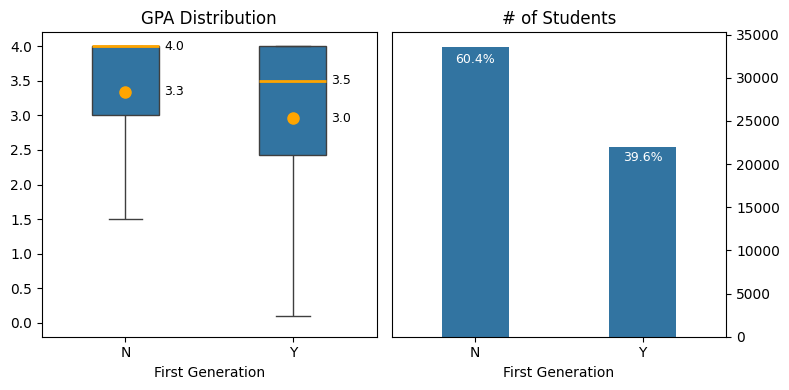

In [5]:
# Plot of GPA difference between first generation and non-first generation students

plot_data = data[['FirstGenerationFlag', 'TermGPA']]

category_counts = plot_data['FirstGenerationFlag'].value_counts().reset_index()
category_counts.columns = ['First Generation', 'Students']
category_counts['Percent'] = (category_counts['Students'] / category_counts['Students'].sum()) * 100
category_counts['Median'] = (plot_data.groupby('FirstGenerationFlag')['TermGPA'].median()).reset_index()['TermGPA']
category_counts['Mean'] = (plot_data.groupby('FirstGenerationFlag')['TermGPA'].mean()).reset_index()['TermGPA']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=False)

# Plot 1
sns.boxplot(data=plot_data,
            x='FirstGenerationFlag',
            y='TermGPA',
            showmeans=True,
            fliersize=0,
            width=0.4,
            ax=ax1,
            medianprops={"color": "orange", "linewidth": 2},
            meanprops={"marker":"o", 
                        "markerfacecolor":"orange", 
                        "markeredgecolor":"orange",
                        "markersize":"8"})

for i, row in category_counts.iterrows():
    median = f"{row['Median']:.1f}"
    bar_height = row['Median']
    ax1.text(x=i+0.23, y=bar_height, s=median, ha='left', va='center', fontsize=9, color='black')
    
    mean = f"{row['Mean']:.1f}"
    bar_height = row['Mean']
    ax1.text(x=i+0.23, y=bar_height, s=mean, ha='left', va='center', fontsize=9, color='black')
    
ax1.set_title('GPA Distribution')
ax1.set_ylabel('')
ax1.set_xlabel('First Generation')

# Plot 2
sns.barplot(data=category_counts,
            x='First Generation',
            y='Students',
            width=0.4,
            ax=ax2)

for i, row in category_counts.iterrows():
    percent = f"{row['Percent']:.1f}%"
    bar_height = row['Students']
    ax2.text(x=i, y=bar_height*0.98, s=percent, ha='center', va='top', fontsize=9, color='white')

ax2.yaxis.tick_right()
ax2.set_title('# of Students')
ax2.set_ylabel('')
ax2.set_xlabel('First Generation')

plt.tight_layout()
plt.show()

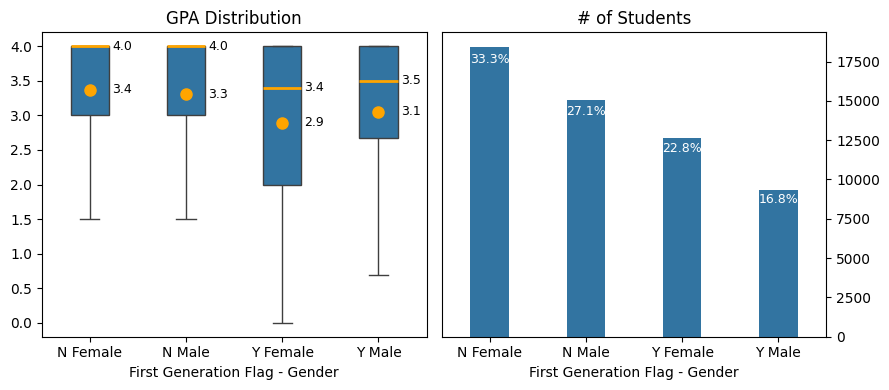

In [19]:
# Plot of GPA difference between first generation and non-first generation students

plot_data = data.loc[data['Gender'] != 'Unknown', ['FirstGenerationFlag', 'Gender', 'TermGPA']].copy()
plot_data['FirstGen'] = plot_data['FirstGenerationFlag'].astype(str) + ' ' + plot_data['Gender'].astype(str)
my_order = sorted(plot_data['FirstGen'].unique())

category_counts = plot_data['FirstGen'].value_counts().reset_index()
category_counts.columns = ['First Generation', 'Students']
category_counts['First Generation'] = pd.Categorical(category_counts['First Generation'], categories=my_order, ordered=True)
category_counts = category_counts.sort_values('First Generation').reset_index(drop=True)
category_counts['Percent'] = (category_counts['Students'] / category_counts['Students'].sum()) * 100
category_counts['Median'] = (plot_data.groupby('FirstGen')['TermGPA'].median()).reset_index()['TermGPA']
category_counts['Mean'] = (plot_data.groupby('FirstGen')['TermGPA'].mean()).reset_index()['TermGPA']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), sharey=False)

# Plot 1
sns.boxplot(data=plot_data,
            x='FirstGen',
            y='TermGPA',
            order=my_order,
            showmeans=True,
            fliersize=0,
            width=0.4,
            ax=ax1,
            medianprops={"color": "orange", "linewidth": 2},
            meanprops={"marker":"o", 
                        "markerfacecolor":"orange", 
                        "markeredgecolor":"orange",
                        "markersize":"8"})

for i, row in category_counts.iterrows():
    median = f"{row['Median']:.1f}"
    bar_height = row['Median']
    ax1.text(x=i+0.23, y=bar_height, s=median, ha='left', va='center', fontsize=9, color='black')
    
    mean = f"{row['Mean']:.1f}"
    bar_height = row['Mean']
    ax1.text(x=i+0.23, y=bar_height, s=mean, ha='left', va='center', fontsize=9, color='black')
    
ax1.set_title('GPA Distribution')
ax1.set_ylabel('')
ax1.set_xlabel('First Generation Flag - Gender')

# Plot 2
sns.barplot(data=category_counts,
            x='First Generation',
            y='Students',
            order=my_order,
            width=0.4,
            ax=ax2)

for i, row in category_counts.iterrows():
    percent = f"{row['Percent']:.1f}%"
    bar_height = row['Students']
    ax2.text(x=i, y=bar_height*0.98, s=percent, ha='center', va='top', fontsize=9, color='white')

ax2.yaxis.tick_right()
ax2.set_title('# of Students')
ax2.set_ylabel('')
ax2.set_xlabel('First Generation Flag - Gender')

plt.tight_layout()
plt.show()

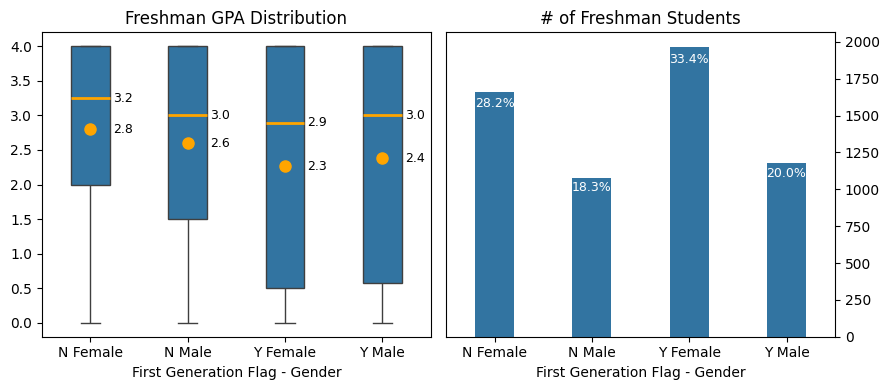

In [28]:
# Plot of GPA difference between first generation and non-first generation students

plot_data = data.loc[(data['Gender'] != 'Unknown') & (data['AcademicLevelEndofTerm'] == 'Freshman'), ['FirstGenerationFlag', 'Gender', 'TermGPA']].copy()
plot_data['FirstGen'] = plot_data['FirstGenerationFlag'].astype(str) + ' ' + plot_data['Gender'].astype(str)
my_order = sorted(plot_data['FirstGen'].unique())

category_counts = plot_data['FirstGen'].value_counts().reset_index()
category_counts.columns = ['First Generation', 'Students']
category_counts['First Generation'] = pd.Categorical(category_counts['First Generation'], categories=my_order, ordered=True)
category_counts = category_counts.sort_values('First Generation').reset_index(drop=True)
category_counts['Percent'] = (category_counts['Students'] / category_counts['Students'].sum()) * 100
category_counts['Median'] = (plot_data.groupby('FirstGen')['TermGPA'].median()).reset_index()['TermGPA']
category_counts['Mean'] = (plot_data.groupby('FirstGen')['TermGPA'].mean()).reset_index()['TermGPA']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), sharey=False)

# Plot 1
sns.boxplot(data=plot_data,
            x='FirstGen',
            y='TermGPA',
            order=my_order,
            showmeans=True,
            fliersize=0,
            width=0.4,
            ax=ax1,
            medianprops={"color": "orange", "linewidth": 2},
            meanprops={"marker":"o", 
                        "markerfacecolor":"orange", 
                        "markeredgecolor":"orange",
                        "markersize":"8"})

for i, row in category_counts.iterrows():
    median = f"{row['Median']:.1f}"
    bar_height = row['Median']
    ax1.text(x=i+0.23, y=bar_height, s=median, ha='left', va='center', fontsize=9, color='black')
    
    mean = f"{row['Mean']:.1f}"
    bar_height = row['Mean']
    ax1.text(x=i+0.23, y=bar_height, s=mean, ha='left', va='center', fontsize=9, color='black')
    
ax1.set_title('Freshman GPA Distribution')
ax1.set_ylabel('')
ax1.set_xlabel('First Generation Flag - Gender')

# Plot 2
sns.barplot(data=category_counts,
            x='First Generation',
            y='Students',
            order=my_order,
            width=0.4,
            ax=ax2)

for i, row in category_counts.iterrows():
    percent = f"{row['Percent']:.1f}%"
    bar_height = row['Students']
    ax2.text(x=i, y=bar_height*0.98, s=percent, ha='center', va='top', fontsize=9, color='white')

ax2.yaxis.tick_right()
ax2.set_title('# of Freshman Students')
ax2.set_ylabel('')
ax2.set_xlabel('First Generation Flag - Gender')

plt.tight_layout()
plt.show()

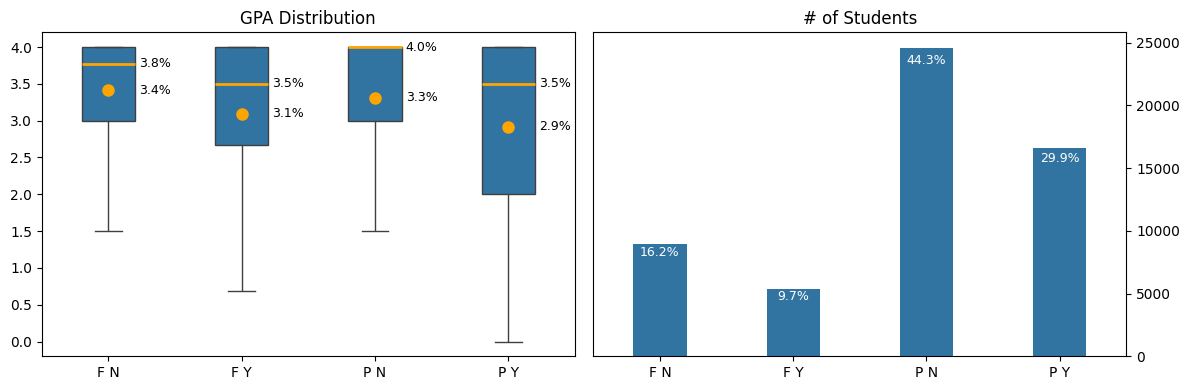

In [65]:
# Plot of GPA difference between first generation and non-first generation students

plot_data = data[['FirstGenerationFlag', 'UAFullTimePartTime', 'TermGPA']].copy()
plot_data['FirstGen'] = plot_data['UAFullTimePartTime'].astype(str) + ' ' + plot_data['FirstGenerationFlag'].astype(str)
my_order = sorted(plot_data['FirstGen'].unique())

category_counts = plot_data['FirstGen'].value_counts().reset_index()
category_counts.columns = ['First Generation', 'Students']
category_counts['First Generation'] = pd.Categorical(category_counts['First Generation'], categories=my_order, ordered=True)
category_counts = category_counts.sort_values('First Generation').reset_index(drop=True)
category_counts['Percent'] = (category_counts['Students'] / category_counts['Students'].sum()) * 100
category_counts['Median'] = (plot_data.groupby('FirstGen')['TermGPA'].median()).reset_index()['TermGPA']
category_counts['Mean'] = (plot_data.groupby('FirstGen')['TermGPA'].mean()).reset_index()['TermGPA']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

# Plot 1
sns.boxplot(data=plot_data,
            x='FirstGen',
            y='TermGPA',
            order=my_order,
            showmeans=True,
            fliersize=0,
            width=0.4,
            ax=ax1,
            medianprops={"color": "orange", "linewidth": 2},
            meanprops={"marker":"o", 
                        "markerfacecolor":"orange", 
                        "markeredgecolor":"orange",
                        "markersize":"8"})

for i, row in category_counts.iterrows():
    median = f"{row['Median']:.1f}%"
    bar_height = row['Median']
    ax1.text(x=i+0.23, y=bar_height, s=median, ha='left', va='center', fontsize=9, color='black')
    
    mean = f"{row['Mean']:.1f}%"
    bar_height = row['Mean']
    ax1.text(x=i+0.23, y=bar_height, s=mean, ha='left', va='center', fontsize=9, color='black')
    
ax1.set_title('GPA Distribution')
ax1.set_ylabel('')
ax1.set_xlabel('')

# Plot 2
sns.barplot(data=category_counts,
            x='First Generation',
            y='Students',
            order=my_order,
            width=0.4,
            ax=ax2)

for i, row in category_counts.iterrows():
    percent = f"{row['Percent']:.1f}%"
    bar_height = row['Students']
    ax2.text(x=i, y=bar_height*0.98, s=percent, ha='center', va='top', fontsize=9, color='white')

ax2.yaxis.tick_right()
ax2.set_title('# of Students')
ax2.set_ylabel('')
ax2.set_xlabel('')

plt.tight_layout()
plt.show()

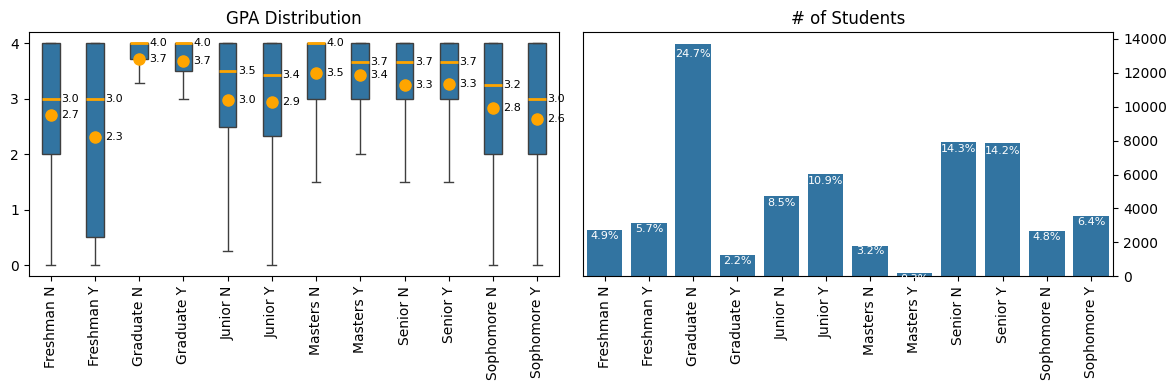

In [23]:
# Plot of GPA difference between first generation and non-first generation students

plot_data = data[['FirstGenerationFlag', 'AcademicLevelEndofTerm', 'TermGPA']].copy()
#plot_data.loc[~plot_data['AcademicLevelEndofTerm'].isin(['Freshman']), 'AcademicLevelEndofTerm'] = 'Other'

plot_data['FirstGen'] = plot_data['AcademicLevelEndofTerm'].astype(str) + ' ' + plot_data['FirstGenerationFlag'].astype(str)
my_order = sorted(plot_data['FirstGen'].unique())

category_counts = plot_data['FirstGen'].value_counts().reset_index()
category_counts.columns = ['First Generation', 'Students']
category_counts['First Generation'] = pd.Categorical(category_counts['First Generation'], categories=my_order, ordered=True)
category_counts = category_counts.sort_values('First Generation').reset_index(drop=True)
category_counts['Percent'] = (category_counts['Students'] / category_counts['Students'].sum()) * 100
category_counts['Median'] = (plot_data.groupby('FirstGen')['TermGPA'].median()).reset_index()['TermGPA']
category_counts['Mean'] = (plot_data.groupby('FirstGen')['TermGPA'].mean()).reset_index()['TermGPA']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

# Plot 1
sns.boxplot(data=plot_data,
            x='FirstGen',
            y='TermGPA',
            order=my_order,
            showmeans=True,
            fliersize=0,
            width=0.4,
            ax=ax1,
            medianprops={"color": "orange", "linewidth": 2},
            meanprops={"marker":"o", 
                        "markerfacecolor":"orange", 
                        "markeredgecolor":"orange",
                        "markersize":"8"})

for i, row in category_counts.iterrows():
    median = f"{row['Median']:.1f}"
    bar_height = row['Median']
    ax1.text(x=i+0.23, y=bar_height, s=median, ha='left', va='center', fontsize=8, color='black')
    
    mean = f"{row['Mean']:.1f}"
    bar_height = row['Mean']
    ax1.text(x=i+0.23, y=bar_height, s=mean, ha='left', va='center', fontsize=8, color='black')
    
ax1.set_title('GPA Distribution')
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('')
ax1.set_xlabel('')

# Plot 2
sns.barplot(data=category_counts,
            x='First Generation',
            y='Students',
            order=my_order,
            width=0.8,
            ax=ax2)

for i, row in category_counts.iterrows():
    percent = f"{row['Percent']:.1f}%"
    bar_height = row['Students']
    ax2.text(x=i, y=bar_height*0.98, s=percent, ha='center', va='top', fontsize=8, color='white')

ax2.yaxis.tick_right()
ax2.tick_params(axis='x', rotation=90)
ax2.set_title('# of Students')
ax2.set_ylabel('')
ax2.set_xlabel('')

plt.tight_layout()
plt.show()

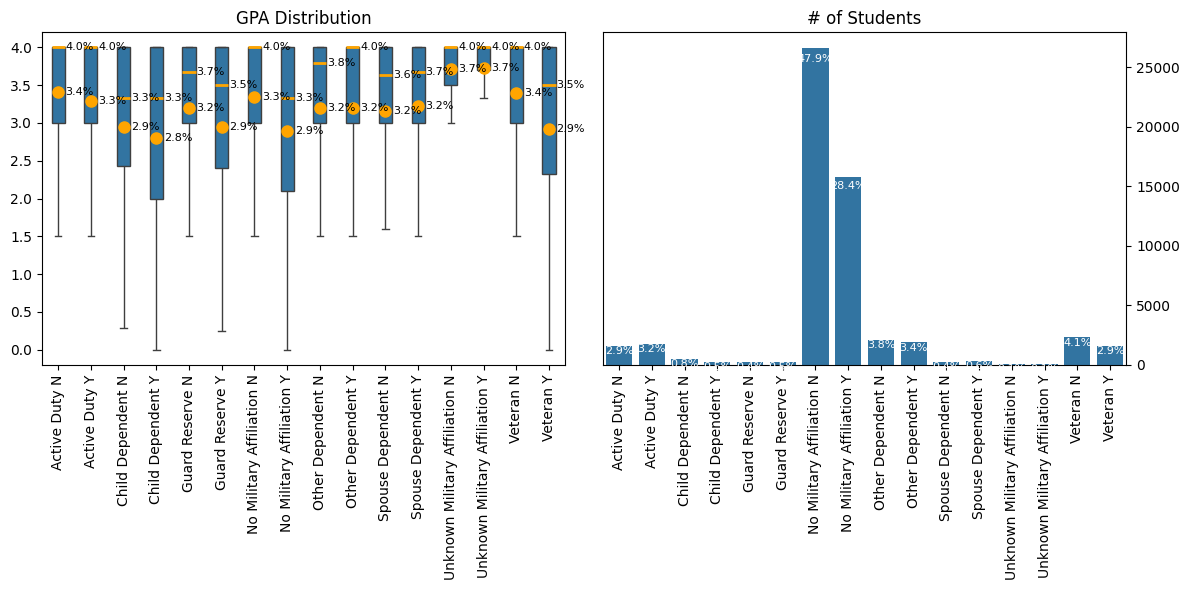

In [79]:
# Plot of GPA difference between first generation and non-first generation students

plot_data = data[['FirstGenerationFlag', 'PrimaryMilitaryAffiliation', 'TermGPA']].copy()

plot_data['FirstGen'] = plot_data['PrimaryMilitaryAffiliation'].astype(str) + ' ' + plot_data['FirstGenerationFlag'].astype(str)
my_order = sorted(plot_data['FirstGen'].unique())

category_counts = plot_data['FirstGen'].value_counts().reset_index()
category_counts.columns = ['First Generation', 'Students']
category_counts['First Generation'] = pd.Categorical(category_counts['First Generation'], categories=my_order, ordered=True)
category_counts = category_counts.sort_values('First Generation').reset_index(drop=True)
category_counts['Percent'] = (category_counts['Students'] / category_counts['Students'].sum()) * 100
category_counts['Median'] = (plot_data.groupby('FirstGen')['TermGPA'].median()).reset_index()['TermGPA']
category_counts['Mean'] = (plot_data.groupby('FirstGen')['TermGPA'].mean()).reset_index()['TermGPA']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# Plot 1
sns.boxplot(data=plot_data,
            x='FirstGen',
            y='TermGPA',
            order=my_order,
            showmeans=True,
            fliersize=0,
            width=0.4,
            ax=ax1,
            medianprops={"color": "orange", "linewidth": 2},
            meanprops={"marker":"o", 
                        "markerfacecolor":"orange", 
                        "markeredgecolor":"orange",
                        "markersize":"8"})

for i, row in category_counts.iterrows():
    median = f"{row['Median']:.1f}%"
    bar_height = row['Median']
    ax1.text(x=i+0.23, y=bar_height, s=median, ha='left', va='center', fontsize=8, color='black')
    
    mean = f"{row['Mean']:.1f}%"
    bar_height = row['Mean']
    ax1.text(x=i+0.23, y=bar_height, s=mean, ha='left', va='center', fontsize=8, color='black')
    
ax1.set_title('GPA Distribution')
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('')
ax1.set_xlabel('')

# Plot 2
sns.barplot(data=category_counts,
            x='First Generation',
            y='Students',
            order=my_order,
            width=0.8,
            ax=ax2)

for i, row in category_counts.iterrows():
    percent = f"{row['Percent']:.1f}%"
    bar_height = row['Students']
    ax2.text(x=i, y=bar_height*0.98, s=percent, ha='center', va='top', fontsize=8, color='white')

ax2.yaxis.tick_right()
ax2.tick_params(axis='x', rotation=90)
ax2.set_title('# of Students')
ax2.set_ylabel('')
ax2.set_xlabel('')

plt.tight_layout()
plt.show()

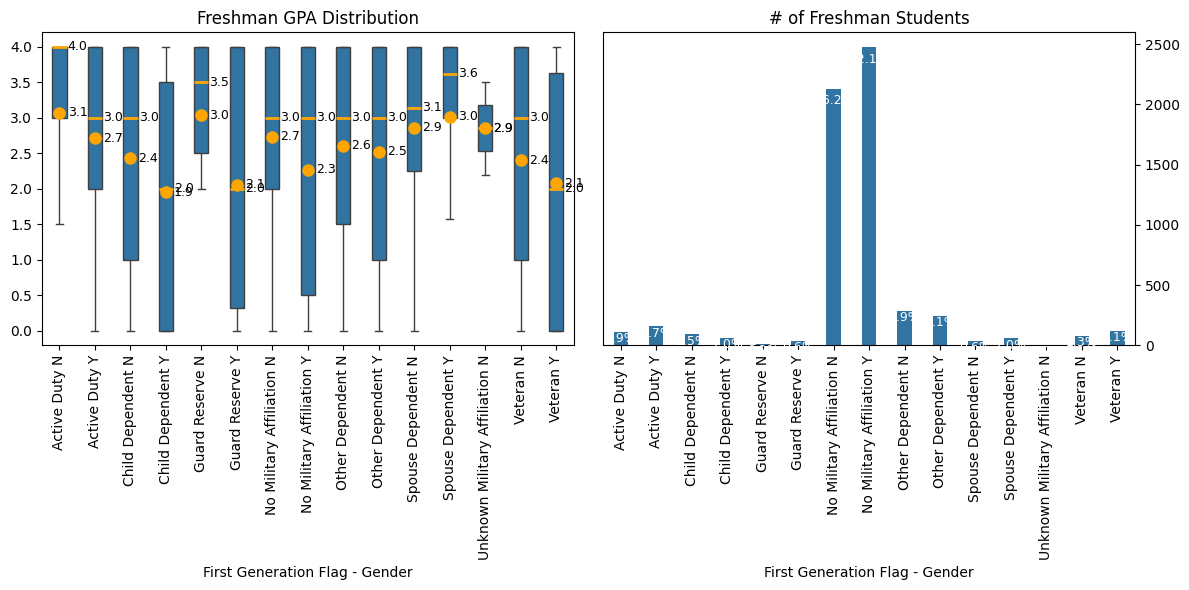

In [31]:
# Plot of GPA difference between first generation and non-first generation students

plot_data = data.loc[data['AcademicLevelEndofTerm'] == 'Freshman', ['FirstGenerationFlag', 'PrimaryMilitaryAffiliation', 'TermGPA']].copy()
plot_data['FirstGen'] = plot_data['PrimaryMilitaryAffiliation'].astype(str) + ' ' + plot_data['FirstGenerationFlag'].astype(str)
my_order = sorted(plot_data['FirstGen'].unique())

category_counts = plot_data['FirstGen'].value_counts().reset_index()
category_counts.columns = ['First Generation', 'Students']
category_counts['First Generation'] = pd.Categorical(category_counts['First Generation'], categories=my_order, ordered=True)
category_counts = category_counts.sort_values('First Generation').reset_index(drop=True)
category_counts['Percent'] = (category_counts['Students'] / category_counts['Students'].sum()) * 100
category_counts['Median'] = (plot_data.groupby('FirstGen')['TermGPA'].median()).reset_index()['TermGPA']
category_counts['Mean'] = (plot_data.groupby('FirstGen')['TermGPA'].mean()).reset_index()['TermGPA']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# Plot 1
sns.boxplot(data=plot_data,
            x='FirstGen',
            y='TermGPA',
            order=my_order,
            showmeans=True,
            fliersize=0,
            width=0.4,
            ax=ax1,
            medianprops={"color": "orange", "linewidth": 2},
            meanprops={"marker":"o", 
                        "markerfacecolor":"orange", 
                        "markeredgecolor":"orange",
                        "markersize":"8"})

for i, row in category_counts.iterrows():
    median = f"{row['Median']:.1f}"
    bar_height = row['Median']
    ax1.text(x=i+0.23, y=bar_height, s=median, ha='left', va='center', fontsize=9, color='black')
    
    mean = f"{row['Mean']:.1f}"
    bar_height = row['Mean']
    ax1.text(x=i+0.23, y=bar_height, s=mean, ha='left', va='center', fontsize=9, color='black')
    
ax1.tick_params(axis='x', rotation=90)
ax1.set_title('Freshman GPA Distribution')
ax1.set_ylabel('')
ax1.set_xlabel('First Generation Flag - Gender')

# Plot 2
sns.barplot(data=category_counts,
            x='First Generation',
            y='Students',
            order=my_order,
            width=0.4,
            ax=ax2)

for i, row in category_counts.iterrows():
    percent = f"{row['Percent']:.1f}%"
    bar_height = row['Students']
    ax2.text(x=i, y=bar_height*0.98, s=percent, ha='center', va='top', fontsize=9, color='white')

ax2.yaxis.tick_right()
ax2.tick_params(axis='x', rotation=90)
ax2.set_title('# of Freshman Students')
ax2.set_ylabel('')
ax2.set_xlabel('First Generation Flag - Gender')

plt.tight_layout()
plt.show()

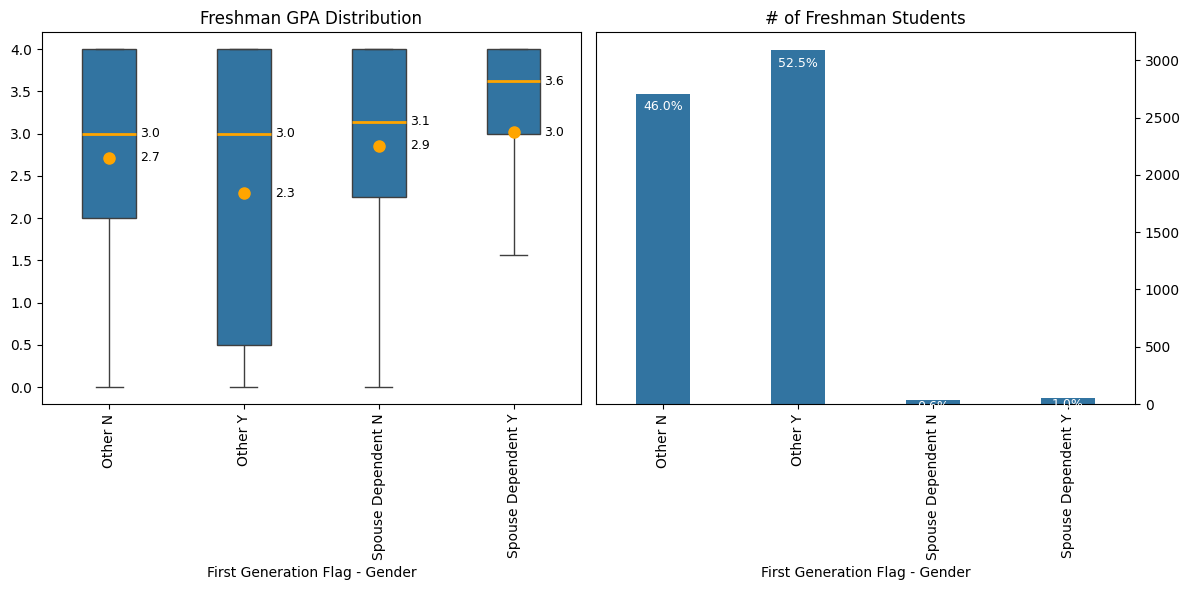

In [33]:
# Plot of GPA difference between first generation and non-first generation students

plot_data = data.loc[data['AcademicLevelEndofTerm'] == 'Freshman', ['FirstGenerationFlag', 'PrimaryMilitaryAffiliation', 'TermGPA']].copy()
plot_data.loc[~plot_data['PrimaryMilitaryAffiliation'].isin(['Spouse Dependent']), 'PrimaryMilitaryAffiliation'] = 'Other'
plot_data['FirstGen'] = plot_data['PrimaryMilitaryAffiliation'].astype(str) + ' ' + plot_data['FirstGenerationFlag'].astype(str)
my_order = sorted(plot_data['FirstGen'].unique())

category_counts = plot_data['FirstGen'].value_counts().reset_index()
category_counts.columns = ['First Generation', 'Students']
category_counts['First Generation'] = pd.Categorical(category_counts['First Generation'], categories=my_order, ordered=True)
category_counts = category_counts.sort_values('First Generation').reset_index(drop=True)
category_counts['Percent'] = (category_counts['Students'] / category_counts['Students'].sum()) * 100
category_counts['Median'] = (plot_data.groupby('FirstGen')['TermGPA'].median()).reset_index()['TermGPA']
category_counts['Mean'] = (plot_data.groupby('FirstGen')['TermGPA'].mean()).reset_index()['TermGPA']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# Plot 1
sns.boxplot(data=plot_data,
            x='FirstGen',
            y='TermGPA',
            order=my_order,
            showmeans=True,
            fliersize=0,
            width=0.4,
            ax=ax1,
            medianprops={"color": "orange", "linewidth": 2},
            meanprops={"marker":"o", 
                        "markerfacecolor":"orange", 
                        "markeredgecolor":"orange",
                        "markersize":"8"})

for i, row in category_counts.iterrows():
    median = f"{row['Median']:.1f}"
    bar_height = row['Median']
    ax1.text(x=i+0.23, y=bar_height, s=median, ha='left', va='center', fontsize=9, color='black')
    
    mean = f"{row['Mean']:.1f}"
    bar_height = row['Mean']
    ax1.text(x=i+0.23, y=bar_height, s=mean, ha='left', va='center', fontsize=9, color='black')
    
ax1.tick_params(axis='x', rotation=90)
ax1.set_title('Freshman GPA Distribution')
ax1.set_ylabel('')
ax1.set_xlabel('First Generation Flag - Gender')

# Plot 2
sns.barplot(data=category_counts,
            x='First Generation',
            y='Students',
            order=my_order,
            width=0.4,
            ax=ax2)

for i, row in category_counts.iterrows():
    percent = f"{row['Percent']:.1f}%"
    bar_height = row['Students']
    ax2.text(x=i, y=bar_height*0.98, s=percent, ha='center', va='top', fontsize=9, color='white')

ax2.yaxis.tick_right()
ax2.tick_params(axis='x', rotation=90)
ax2.set_title('# of Freshman Students')
ax2.set_ylabel('')
ax2.set_xlabel('First Generation Flag - Gender')

plt.tight_layout()
plt.show()

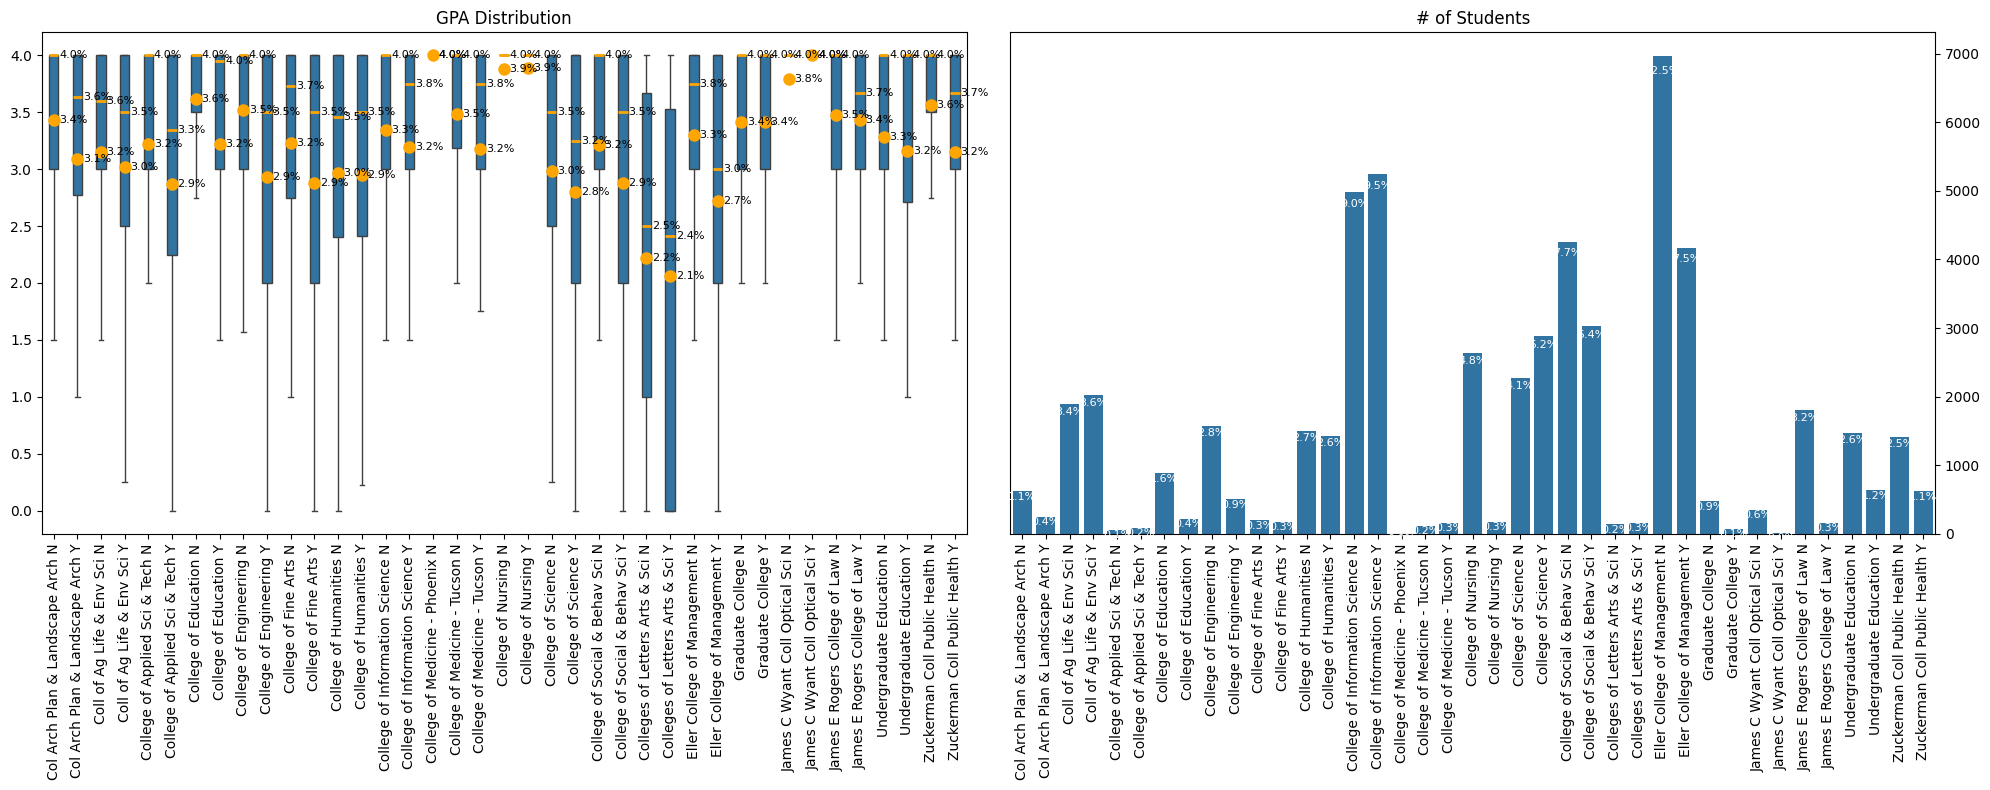

In [93]:
# Plot of GPA difference between first generation and non-first generation students

plot_data = data[['FirstGenerationFlag', 'College', 'TermGPA']].copy()

plot_data['FirstGen'] = plot_data['College'].astype(str) + ' ' + plot_data['FirstGenerationFlag'].astype(str)
my_order = sorted(plot_data['FirstGen'].unique())

category_counts = plot_data['FirstGen'].value_counts().reset_index()
category_counts.columns = ['First Generation', 'Students']
category_counts['First Generation'] = pd.Categorical(category_counts['First Generation'], categories=my_order, ordered=True)
category_counts = category_counts.sort_values('First Generation').reset_index(drop=True)
category_counts['Percent'] = (category_counts['Students'] / category_counts['Students'].sum()) * 100
category_counts['Median'] = (plot_data.groupby('FirstGen')['TermGPA'].median()).reset_index()['TermGPA']
category_counts['Mean'] = (plot_data.groupby('FirstGen')['TermGPA'].mean()).reset_index()['TermGPA']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=False)

# Plot 1
sns.boxplot(data=plot_data,
            x='FirstGen',
            y='TermGPA',
            order=my_order,
            showmeans=True,
            fliersize=0,
            width=0.4,
            ax=ax1,
            medianprops={"color": "orange", "linewidth": 2},
            meanprops={"marker":"o", 
                        "markerfacecolor":"orange", 
                        "markeredgecolor":"orange",
                        "markersize":"8"})

for i, row in category_counts.iterrows():
    median = f"{row['Median']:.1f}%"
    bar_height = row['Median']
    ax1.text(x=i+0.23, y=bar_height, s=median, ha='left', va='center', fontsize=8, color='black')
    
    mean = f"{row['Mean']:.1f}%"
    bar_height = row['Mean']
    ax1.text(x=i+0.23, y=bar_height, s=mean, ha='left', va='center', fontsize=8, color='black')
    
ax1.set_title('GPA Distribution')
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('')
ax1.set_xlabel('')

# Plot 2
sns.barplot(data=category_counts,
            x='First Generation',
            y='Students',
            order=my_order,
            width=0.8,
            ax=ax2)

for i, row in category_counts.iterrows():
    percent = f"{row['Percent']:.1f}%"
    bar_height = row['Students']
    ax2.text(x=i, y=bar_height*0.98, s=percent, ha='center', va='top', fontsize=8, color='white')

ax2.yaxis.tick_right()
ax2.tick_params(axis='x', rotation=90)
ax2.set_title('# of Students')
ax2.set_ylabel('')
ax2.set_xlabel('')

plt.tight_layout()
plt.show()

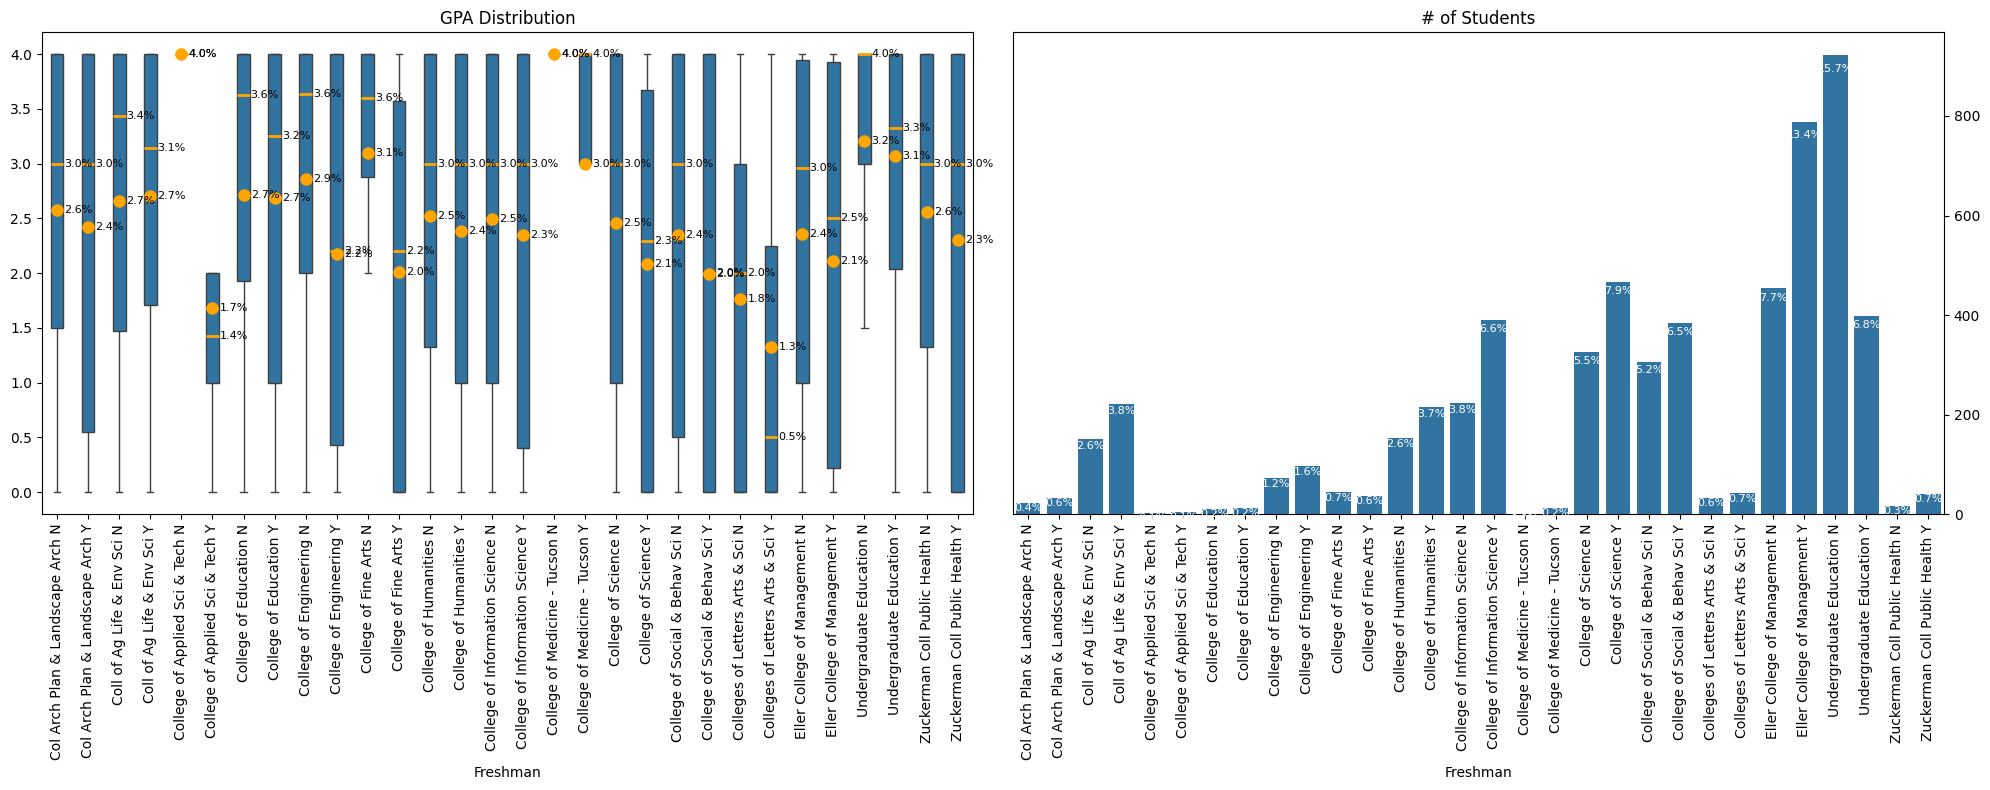

In [94]:
# Plot of GPA difference between first generation and non-first generation students

plot_data = data.loc[data['AcademicLevelEndofTerm'] == 'Freshman', ['FirstGenerationFlag', 'College', 'TermGPA']].copy()

plot_data['FirstGen'] = plot_data['College'].astype(str) + ' ' + plot_data['FirstGenerationFlag'].astype(str)
my_order = sorted(plot_data['FirstGen'].unique())

category_counts = plot_data['FirstGen'].value_counts().reset_index()
category_counts.columns = ['First Generation', 'Students']
category_counts['First Generation'] = pd.Categorical(category_counts['First Generation'], categories=my_order, ordered=True)
category_counts = category_counts.sort_values('First Generation').reset_index(drop=True)
category_counts['Percent'] = (category_counts['Students'] / category_counts['Students'].sum()) * 100
category_counts['Median'] = (plot_data.groupby('FirstGen')['TermGPA'].median()).reset_index()['TermGPA']
category_counts['Mean'] = (plot_data.groupby('FirstGen')['TermGPA'].mean()).reset_index()['TermGPA']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=False)

# Plot 1
sns.boxplot(data=plot_data,
            x='FirstGen',
            y='TermGPA',
            order=my_order,
            showmeans=True,
            fliersize=0,
            width=0.4,
            ax=ax1,
            medianprops={"color": "orange", "linewidth": 2},
            meanprops={"marker":"o", 
                        "markerfacecolor":"orange", 
                        "markeredgecolor":"orange",
                        "markersize":"8"})

for i, row in category_counts.iterrows():
    median = f"{row['Median']:.1f}%"
    bar_height = row['Median']
    ax1.text(x=i+0.23, y=bar_height, s=median, ha='left', va='center', fontsize=8, color='black')
    
    mean = f"{row['Mean']:.1f}%"
    bar_height = row['Mean']
    ax1.text(x=i+0.23, y=bar_height, s=mean, ha='left', va='center', fontsize=8, color='black')
    
ax1.set_title('GPA Distribution')
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('')
ax1.set_xlabel('Freshman')

# Plot 2
sns.barplot(data=category_counts,
            x='First Generation',
            y='Students',
            order=my_order,
            width=0.8,
            ax=ax2)

for i, row in category_counts.iterrows():
    percent = f"{row['Percent']:.1f}%"
    bar_height = row['Students']
    ax2.text(x=i, y=bar_height*0.98, s=percent, ha='center', va='top', fontsize=8, color='white')

ax2.yaxis.tick_right()
ax2.tick_params(axis='x', rotation=90)
ax2.set_title('# of Students')
ax2.set_ylabel('')
ax2.set_xlabel('Freshman')

plt.tight_layout()
plt.show()

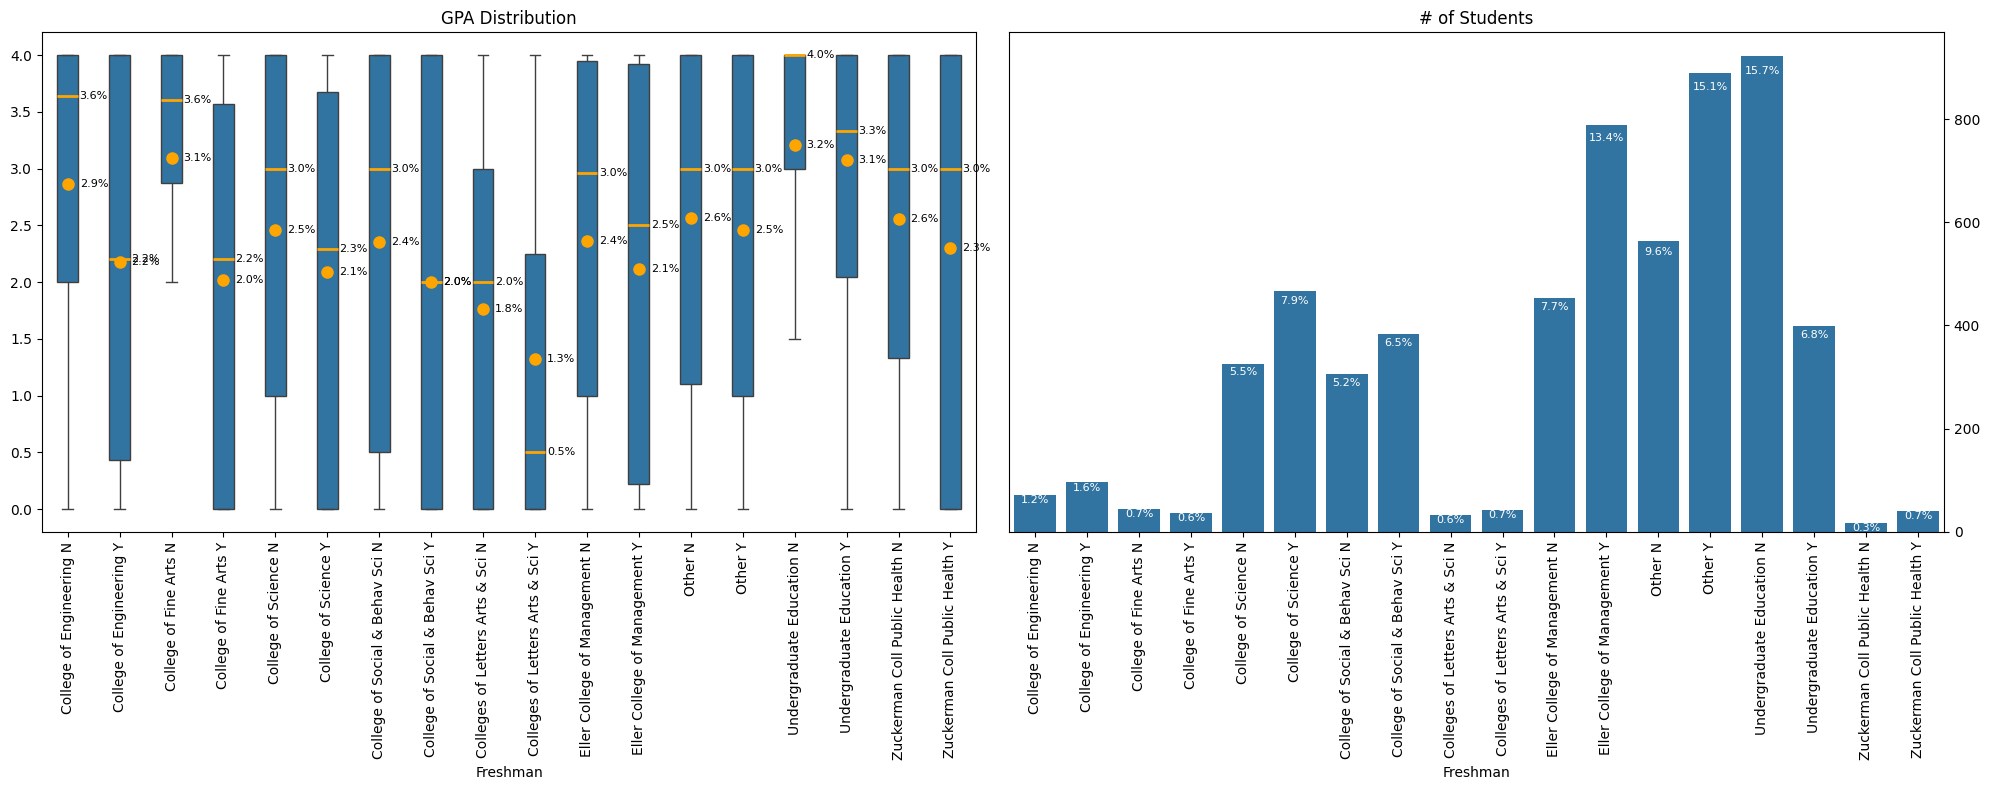

In [49]:
# Plot of GPA difference between first generation and non-first generation students

plot_data = data.loc[data['AcademicLevelEndofTerm'] == 'Freshman', ['FirstGenerationFlag', 'College', 'TermGPA']].copy()

plot_data.loc[~plot_data['College'].isin(['College of Engineering', 
                                          'College of Fine Arts', 
                                          'College of Science', 
                                          'College of Social & Behav Sci',
                                          'Colleges of Letters Arts & Sci',
                                          'Eller College of Management',
                                          'Undergraduate Education',
                                          'Zuckerman Coll Public Health']), 'College'] = 'Other'

plot_data['FirstGen'] = plot_data['College'].astype(str) + ' ' + plot_data['FirstGenerationFlag'].astype(str)
my_order = sorted(plot_data['FirstGen'].unique())

category_counts = plot_data['FirstGen'].value_counts().reset_index()
category_counts.columns = ['First Generation', 'Students']
category_counts['First Generation'] = pd.Categorical(category_counts['First Generation'], categories=my_order, ordered=True)
category_counts = category_counts.sort_values('First Generation').reset_index(drop=True)
category_counts['Percent'] = (category_counts['Students'] / category_counts['Students'].sum()) * 100
category_counts['Median'] = (plot_data.groupby('FirstGen')['TermGPA'].median()).reset_index()['TermGPA']
category_counts['Mean'] = (plot_data.groupby('FirstGen')['TermGPA'].mean()).reset_index()['TermGPA']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=False)

# Plot 1
sns.boxplot(data=plot_data,
            x='FirstGen',
            y='TermGPA',
            order=my_order,
            showmeans=True,
            fliersize=0,
            width=0.4,
            ax=ax1,
            medianprops={"color": "orange", "linewidth": 2},
            meanprops={"marker":"o", 
                        "markerfacecolor":"orange", 
                        "markeredgecolor":"orange",
                        "markersize":"8"})

for i, row in category_counts.iterrows():
    median = f"{row['Median']:.1f}%"
    bar_height = row['Median']
    ax1.text(x=i+0.23, y=bar_height, s=median, ha='left', va='center', fontsize=8, color='black')
    
    mean = f"{row['Mean']:.1f}%"
    bar_height = row['Mean']
    ax1.text(x=i+0.23, y=bar_height, s=mean, ha='left', va='center', fontsize=8, color='black')
    
ax1.set_title('GPA Distribution')
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('')
ax1.set_xlabel('Freshman')

# Plot 2
sns.barplot(data=category_counts,
            x='First Generation',
            y='Students',
            order=my_order,
            width=0.8,
            ax=ax2)

for i, row in category_counts.iterrows():
    percent = f"{row['Percent']:.1f}%"
    bar_height = row['Students']
    ax2.text(x=i, y=bar_height*0.98, s=percent, ha='center', va='top', fontsize=8, color='white')

ax2.yaxis.tick_right()
ax2.tick_params(axis='x', rotation=90)
ax2.set_title('# of Students')
ax2.set_ylabel('')
ax2.set_xlabel('Freshman')

plt.tight_layout()
plt.show()

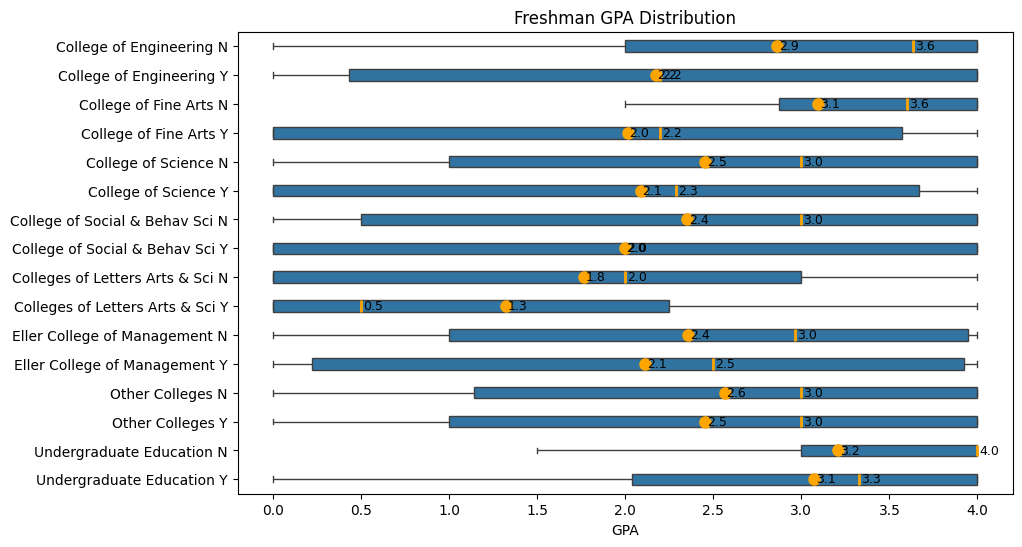

In [60]:
# Plot of GPA difference between first generation and non-first generation students

plot_data = data.loc[data['AcademicLevelEndofTerm'] == 'Freshman', ['FirstGenerationFlag', 'College', 'TermGPA']].copy()

plot_data.loc[~plot_data['College'].isin(['College of Engineering', 
                                          'College of Fine Arts', 
                                          'College of Science', 
                                          'College of Social & Behav Sci',
                                          'Colleges of Letters Arts & Sci',
                                          'Eller College of Management',
                                          'Undergraduate Education']), 'College'] = 'Other Colleges'

plot_data['FirstGen'] = plot_data['College'].astype(str) + ' ' + plot_data['FirstGenerationFlag'].astype(str)
my_order = sorted(plot_data['FirstGen'].unique())

category_counts = plot_data['FirstGen'].value_counts().reset_index()
category_counts.columns = ['First Generation', 'Students']
category_counts['First Generation'] = pd.Categorical(category_counts['First Generation'], categories=my_order, ordered=True)
category_counts = category_counts.sort_values('First Generation').reset_index(drop=True)
category_counts['Percent'] = (category_counts['Students'] / category_counts['Students'].sum()) * 100
category_counts['Median'] = (plot_data.groupby('FirstGen')['TermGPA'].median()).reset_index()['TermGPA']
category_counts['Mean'] = (plot_data.groupby('FirstGen')['TermGPA'].mean()).reset_index()['TermGPA']
category_counts['1st_Quartile'] = (plot_data.groupby('FirstGen')['TermGPA'].quantile(0.25)).reset_index()['TermGPA']


fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(data=plot_data,
            x='TermGPA',
            y='FirstGen',
            order=my_order,
            showmeans=True,
            fliersize=0,
            width=0.4,
            ax=ax,
            medianprops={"color": "orange", "linewidth": 2},
            meanprops={"marker":"o", 
                        "markerfacecolor":"orange", 
                        "markeredgecolor":"orange",
                        "markersize":"8"})

for i, row in category_counts.iterrows():
    median = f"{row['Median']:.1f}"
    bar_height = row['Median']
    ax.text(x=row['Median'] + 0.01, 
             y=i,     
             s=median, 
             ha='left', 
             va='center', 
             fontsize=9, 
             color='black')
    
    mean = f"{row['Mean']:.1f}"
    bar_height = row['Mean']
    ax.text(x=row['Mean'] + 0.01, 
             y=i, 
             s=mean, 
             ha='left', 
             va='center', 
             fontsize=9, 
             color='black')
    
ax.set_title('Freshman GPA Distribution')
ax.tick_params(axis='y', rotation=0)
ax.set_ylabel('')
ax.set_xlabel('GPA')


plt.show()

In [61]:
category_counts

,First Generation,Students,Percent,Median,Mean,1st_Quartile
0,College of Engineering N,72,1.224282,3.635,2.862083,2.0000
1,College of Engineering Y,97,1.649379,2.200,2.173814,0.4300
2,College of Fine Arts N,44,0.748172,3.600,3.096591,2.8750
3,College of Fine Arts Y,37,0.629145,2.200,2.014054,0.0000
4,College of Science N,325,5.526271,3.000,2.454338,1.0000
5,College of Science Y,467,7.940826,2.290,2.088266,0.0000
6,College of Social & Behav Sci N,305,5.186193,3.000,2.351115,0.5000
7,College of Social & Behav Sci Y,384,6.529502,2.000,1.997266,0.0000
8,Colleges of Letters Arts & Sci N,33,0.561129,2.000,1.764545,0.0000
9,Colleges of Letters Arts & Sci Y,42,0.714164,0.500,1.323095,0.0000


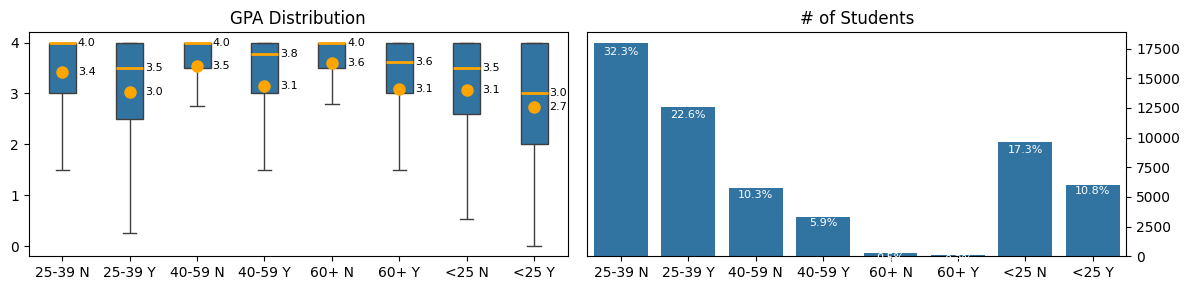

In [46]:
# Plot of GPA difference between first generation and non-first generation students

plot_data = data[['FirstGenerationFlag', 'AgeGroups', 'TermGPA']].copy()

plot_data['FirstGen'] = plot_data['AgeGroups'].astype(str) + ' ' + plot_data['FirstGenerationFlag'].astype(str)
my_order = sorted(plot_data['FirstGen'].unique())

category_counts = plot_data['FirstGen'].value_counts().reset_index()
category_counts.columns = ['First Generation', 'Students']
category_counts['First Generation'] = pd.Categorical(category_counts['First Generation'], categories=my_order, ordered=True)
category_counts = category_counts.sort_values('First Generation').reset_index(drop=True)
category_counts['Percent'] = (category_counts['Students'] / category_counts['Students'].sum()) * 100
category_counts['Median'] = (plot_data.groupby('FirstGen')['TermGPA'].median()).reset_index()['TermGPA']
category_counts['Mean'] = (plot_data.groupby('FirstGen')['TermGPA'].mean()).reset_index()['TermGPA']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), sharey=False)

# Plot 1
sns.boxplot(data=plot_data,
            x='FirstGen',
            y='TermGPA',
            order=my_order,
            showmeans=True,
            fliersize=0,
            width=0.4,
            ax=ax1,
            medianprops={"color": "orange", "linewidth": 2},
            meanprops={"marker":"o", 
                        "markerfacecolor":"orange", 
                        "markeredgecolor":"orange",
                        "markersize":"8"})

for i, row in category_counts.iterrows():
    median = f"{row['Median']:.1f}"
    bar_height = row['Median']
    ax1.text(x=i+0.23, y=bar_height, s=median, ha='left', va='center', fontsize=8, color='black')
    
    mean = f"{row['Mean']:.1f}"
    bar_height = row['Mean']
    ax1.text(x=i+0.23, y=bar_height, s=mean, ha='left', va='center', fontsize=8, color='black')
    
ax1.set_title('GPA Distribution')
ax1.set_ylabel('')
ax1.set_xlabel('')

# Plot 2
sns.barplot(data=category_counts,
            x='First Generation',
            y='Students',
            order=my_order,
            width=0.8,
            ax=ax2)

for i, row in category_counts.iterrows():
    percent = f"{row['Percent']:.1f}%"
    bar_height = row['Students']
    ax2.text(x=i, y=bar_height*0.98, s=percent, ha='center', va='top', fontsize=8, color='white')

ax2.yaxis.tick_right()
ax2.set_title('# of Students')
ax2.set_ylabel('')
ax2.set_xlabel('')

plt.tight_layout()
plt.show()

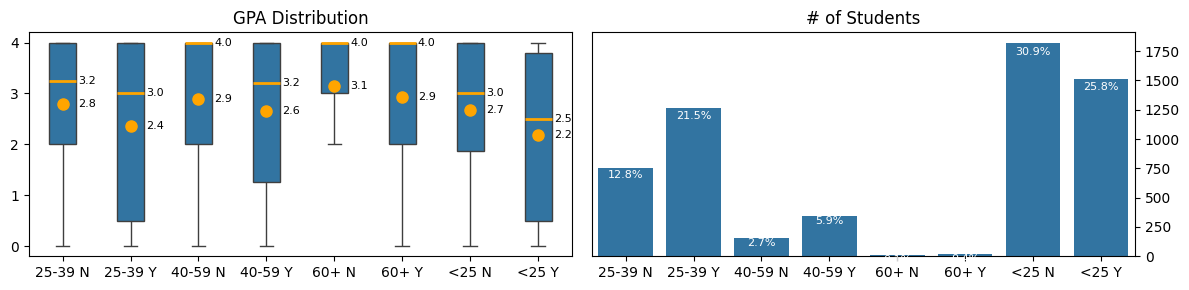

In [44]:
# Plot of GPA difference between first generation and non-first generation students

plot_data = data.loc[data['AcademicLevelEndofTerm'] == 'Freshman', ['FirstGenerationFlag', 'AgeGroups', 'TermGPA']].copy()

plot_data['FirstGen'] = plot_data['AgeGroups'].astype(str) + ' ' + plot_data['FirstGenerationFlag'].astype(str)
my_order = sorted(plot_data['FirstGen'].unique())

category_counts = plot_data['FirstGen'].value_counts().reset_index()
category_counts.columns = ['First Generation', 'Students']
category_counts['First Generation'] = pd.Categorical(category_counts['First Generation'], categories=my_order, ordered=True)
category_counts = category_counts.sort_values('First Generation').reset_index(drop=True)
category_counts['Percent'] = (category_counts['Students'] / category_counts['Students'].sum()) * 100
category_counts['Median'] = (plot_data.groupby('FirstGen')['TermGPA'].median()).reset_index()['TermGPA']
category_counts['Mean'] = (plot_data.groupby('FirstGen')['TermGPA'].mean()).reset_index()['TermGPA']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), sharey=False)

# Plot 1
sns.boxplot(data=plot_data,
            x='FirstGen',
            y='TermGPA',
            order=my_order,
            showmeans=True,
            fliersize=0,
            width=0.4,
            ax=ax1,
            medianprops={"color": "orange", "linewidth": 2},
            meanprops={"marker":"o", 
                        "markerfacecolor":"orange", 
                        "markeredgecolor":"orange",
                        "markersize":"8"})

for i, row in category_counts.iterrows():
    median = f"{row['Median']:.1f}"
    bar_height = row['Median']
    ax1.text(x=i+0.23, y=bar_height, s=median, ha='left', va='center', fontsize=8, color='black')
    
    mean = f"{row['Mean']:.1f}"
    bar_height = row['Mean']
    ax1.text(x=i+0.23, y=bar_height, s=mean, ha='left', va='center', fontsize=8, color='black')
    
ax1.set_title('GPA Distribution')
ax1.set_ylabel('')
ax1.set_xlabel('')

# Plot 2
sns.barplot(data=category_counts,
            x='First Generation',
            y='Students',
            order=my_order,
            width=0.8,
            ax=ax2)

for i, row in category_counts.iterrows():
    percent = f"{row['Percent']:.1f}%"
    bar_height = row['Students']
    ax2.text(x=i, y=bar_height*0.98, s=percent, ha='center', va='top', fontsize=8, color='white')

ax2.yaxis.tick_right()
ax2.set_title('# of Students')
ax2.set_ylabel('')
ax2.set_xlabel('')

plt.tight_layout()
plt.show()

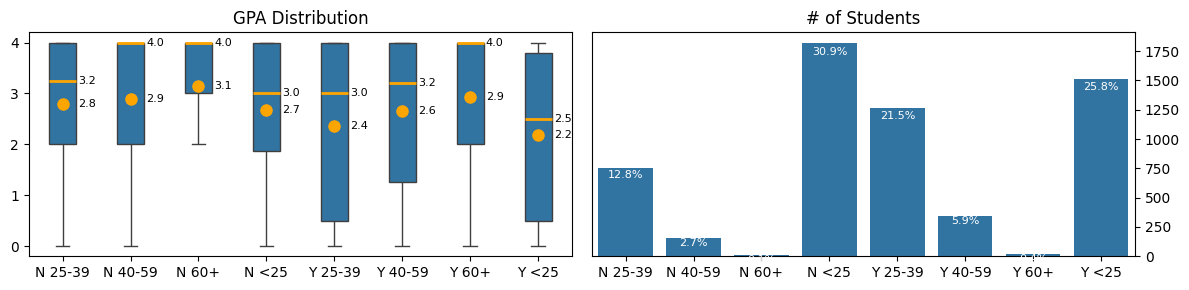

In [47]:
# Plot of GPA difference between first generation and non-first generation students

plot_data = data.loc[data['AcademicLevelEndofTerm'] == 'Freshman', ['FirstGenerationFlag', 'AgeGroups', 'TermGPA']].copy()

plot_data['FirstGen'] = plot_data['FirstGenerationFlag'].astype(str) + ' ' + plot_data['AgeGroups'].astype(str)
my_order = sorted(plot_data['FirstGen'].unique())

category_counts = plot_data['FirstGen'].value_counts().reset_index()
category_counts.columns = ['First Generation', 'Students']
category_counts['First Generation'] = pd.Categorical(category_counts['First Generation'], categories=my_order, ordered=True)
category_counts = category_counts.sort_values('First Generation').reset_index(drop=True)
category_counts['Percent'] = (category_counts['Students'] / category_counts['Students'].sum()) * 100
category_counts['Median'] = (plot_data.groupby('FirstGen')['TermGPA'].median()).reset_index()['TermGPA']
category_counts['Mean'] = (plot_data.groupby('FirstGen')['TermGPA'].mean()).reset_index()['TermGPA']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), sharey=False)

# Plot 1
sns.boxplot(data=plot_data,
            x='FirstGen',
            y='TermGPA',
            order=my_order,
            showmeans=True,
            fliersize=0,
            width=0.4,
            ax=ax1,
            medianprops={"color": "orange", "linewidth": 2},
            meanprops={"marker":"o", 
                        "markerfacecolor":"orange", 
                        "markeredgecolor":"orange",
                        "markersize":"8"})

for i, row in category_counts.iterrows():
    median = f"{row['Median']:.1f}"
    bar_height = row['Median']
    ax1.text(x=i+0.23, y=bar_height, s=median, ha='left', va='center', fontsize=8, color='black')
    
    mean = f"{row['Mean']:.1f}"
    bar_height = row['Mean']
    ax1.text(x=i+0.23, y=bar_height, s=mean, ha='left', va='center', fontsize=8, color='black')
    
ax1.set_title('GPA Distribution')
ax1.set_ylabel('')
ax1.set_xlabel('')

# Plot 2
sns.barplot(data=category_counts,
            x='First Generation',
            y='Students',
            order=my_order,
            width=0.8,
            ax=ax2)

for i, row in category_counts.iterrows():
    percent = f"{row['Percent']:.1f}%"
    bar_height = row['Students']
    ax2.text(x=i, y=bar_height*0.98, s=percent, ha='center', va='top', fontsize=8, color='white')

ax2.yaxis.tick_right()
ax2.set_title('# of Students')
ax2.set_ylabel('')
ax2.set_xlabel('')

plt.tight_layout()
plt.show()

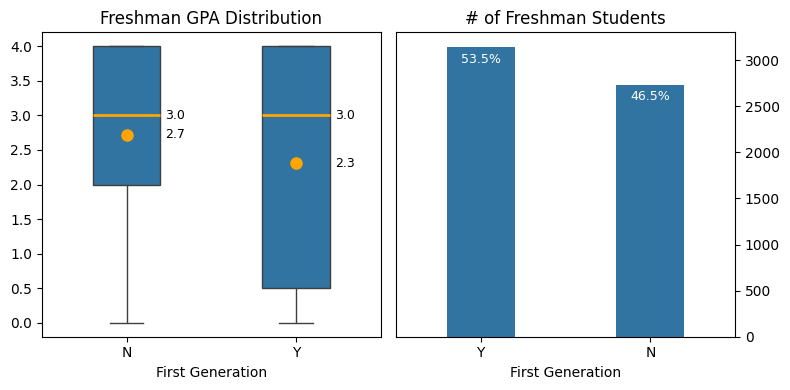

In [45]:
# Plot of GPA difference between first generation and non-first generation students

plot_data = data.loc[data['AcademicLevelEndofTerm'] == 'Freshman', ['FirstGenerationFlag', 'TermGPA']]

category_counts = plot_data['FirstGenerationFlag'].value_counts().reset_index()
category_counts.columns = ['First Generation', 'Students']
category_counts['Percent'] = (category_counts['Students'] / category_counts['Students'].sum()) * 100
category_counts['Median'] = (plot_data.groupby('FirstGenerationFlag')['TermGPA'].median()).reset_index()['TermGPA']
category_counts['Mean'] = (plot_data.groupby('FirstGenerationFlag')['TermGPA'].mean()).reset_index()['TermGPA']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=False)

# Plot 1
sns.boxplot(data=plot_data,
            x='FirstGenerationFlag',
            y='TermGPA',
            showmeans=True,
            fliersize=0,
            width=0.4,
            ax=ax1,
            medianprops={"color": "orange", "linewidth": 2},
            meanprops={"marker":"o", 
                        "markerfacecolor":"orange", 
                        "markeredgecolor":"orange",
                        "markersize":"8"})

for i, row in category_counts.iterrows():
    median = f"{row['Median']:.1f}"
    bar_height = row['Median']
    ax1.text(x=i+0.23, y=bar_height, s=median, ha='left', va='center', fontsize=9, color='black')
    
    mean = f"{row['Mean']:.1f}"
    bar_height = row['Mean']
    ax1.text(x=i+0.23, y=bar_height, s=mean, ha='left', va='center', fontsize=9, color='black')
    
ax1.set_title('Freshman GPA Distribution')
ax1.set_ylabel('')
ax1.set_xlabel('First Generation')

# Plot 2
sns.barplot(data=category_counts,
            x='First Generation',
            y='Students',
            width=0.4,
            ax=ax2)

for i, row in category_counts.iterrows():
    percent = f"{row['Percent']:.1f}%"
    bar_height = row['Students']
    ax2.text(x=i, y=bar_height*0.98, s=percent, ha='center', va='top', fontsize=9, color='white')

ax2.yaxis.tick_right()
ax2.set_title('# of Freshman Students')
ax2.set_ylabel('')
ax2.set_xlabel('First Generation')

plt.tight_layout()
plt.show()

In [88]:
category_counts

,First Generation,Students,Percent,Median,Mean
0,N,33574,60.4,4.0,3.3
1,Y,21995,39.6,3.5,3.0


In [55]:
category_counts['Students'].sum()

55569

In [58]:
category_counts['Students'] / category_counts['Students'].sum()

0    0.604186
1    0.395814
Name: Students, dtype: float64

In [63]:
category_counts['Percent'] = ((category_counts['Students'] / category_counts['Students'].sum()) * 100).round(1)

In [73]:
plot_data['FirstGenerationFlag'].value_counts().reset_index()

,FirstGenerationFlag,count
0,N,33574
1,Y,21995


In [86]:
((plot_data.groupby('FirstGenerationFlag')['TermGPA'].mean()).round(1)).reset_index()['TermGPA']

0    3.3
1    3.0
Name: TermGPA, dtype: float64

In [53]:
plot_data = data[['FirstGenerationFlag', 'Gender', 'TermGPA']].copy()
plot_data['Combo'] = plot_data['Gender'].astype(str) + ' ' + plot_data['FirstGenerationFlag'].astype(str)

In [54]:
plot_data

,FirstGenerationFlag,Gender,TermGPA,Combo
0,N,Female,3.75,Female N
1,N,Male,4.00,Male N
3,N,Female,4.00,Female N
4,Y,Male,2.00,Male Y
5,N,Female,4.00,Female N
...,...,...,...,...
66423,Y,Female,4.00,Female Y
66424,N,Female,4.00,Female N
66426,N,Male,4.00,Male N
66427,N,Female,3.67,Female N


In [39]:
data.loc[data['PrimaryMilitaryAffiliation'] == 'Spouse Dependent', ['FirstGenerationFlag']].value_counts()

FirstGenerationFlag
Y                      339
N                      203
Name: count, dtype: int64